# PBMC analysis
## Xiaonan Wang
## 06Aug2020

Samples: 
- A1: PBMC1
- A4: PBMC2
- B4: PBMC3

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import anndata
import scrublet as scr

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)
sc.logging.print_versions()

/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.5.0 anndata==0.7.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.7.0


In [2]:
#################################################################################################
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:.0f})".format(pct, absolute)

def lv_stat_barplot(data, splitby='key_labels', colorby='louvain_groups', hatch=True, ylab="% in each group", 
                    xlab="Clusters", figsize=(10, 3), startangle = 90, ncols=3, stacked=True, plotMethod='Barplot', 
                    orientation  = 'vertical', fontsize=11, bbox_to_anchor=(1.2, 0.34), color=None, save=None):
    """\
    User defined barplot function
    
    Parameters
    ----------
    adata
        Annotated data matrix
    splitby
        The key of the observations for spliting the bars. Default: key_labels
    colorby    
        The key of the obvervations for coloring the bars. Default: louvain_groups
    hatch
        True/False. whether to use hatch. Default: True
    ylab
        Label for y axis. Default: % in each group
    xlab
        Label for x axis. Default: Clusters
    figsize
        Figure of the figure. Default: (10,3)
    startangle
        Startangle for pie chart. Default: 90
    ncols
        Number of plots per row, onlly for pie chart. Default: 3
    stacked
        True/False. Whether to stack the bars. Default: True
    plotMethod
        Type of plot, options: Barplot, Stackedarea, Panel_Column_Chart and PieChart. Default: Barplot
    orientation
        Orientation of barplot. Default: vertical
    fontsize
        fontsize of labels in pie chart. Default: 11
    color
        User defined color for barplot. Default: None
    save
        File name for saving the plot
    
    Returns
    -------
    **User defined type of plot, either barplot or piechart**
    
    Examples
    --------
    >>> lv_stat_barplot(adata, xlab="Louvain Clusters", splitby="Louvain_Clusters", colorby="Donor", color='white', save='xxx.pdf')
    
    """
    
    if splitby in data.obs_keys():
        g1D = data.obs[splitby]
    elif splitby in data.var_names:
        g1D = data[:, splitby].X
        g1D = ['Positive' if x > 0 else 'Negative' for x in g1D]
        g1D = pd.Series(g1D, dtype = 'category')
        g1D = g1D.cat.reorder_categories(['Negative', 'Positive'])
        g1D = g1D.values
    else:
        raise ValueError('"' + splitby + '" is invalid!'
                                 + ' specify valid sample annotation, one of '
                                 + str(data.obs_keys()) + ' or a gene name '
                                 + str(data.var_names))
    
    if colorby in data.obs_keys():
        g2D = data.obs[colorby]
    elif colorby in data.var_names:
        g2D = data[:, colorby].X
        g2D = ['Positive' if x > 0 else 'Negative' for x in g2D]
        g2D = pd.Series(g2D, dtype = 'category')
        g2D = g2D.cat.reorder_categories(['Negative', 'Positive'])
        g2D = g2D.values
    else:
        raise ValueError('"' + colorby + '" is invalid!'
                                 + ' specify valid sample annotation, one of '
                                 + str(data.obs_keys()) + ' or a gene name '
                                 + str(data.var_names))
    
    df = pd.crosstab(g1D, g2D)
    df_new = df.div(df.sum(axis=1),axis=0)
    
    #print(df_new)
    if plotMethod=='Barplot':
        fig, ax = plt.subplots(figsize= figsize)
        if color is None:
            color = [[vega_20_scanpy[x]]*df_new.shape[0] for x in range(df_new.shape[1])]
            color = np.stack(color)
            #print(color)
        if orientation == 'horizontal':
            df_new = -df_new
            df_new.plot.barh(stacked=stacked, color=color, edgecolor="black", ax=ax)
            plt.xticks(np.arange(0, 101, 20)/-100)
            ax.set_ylabel(xlab)
            ax.set_xlabel(ylab)
            ax.set_xticklabels(np.arange(100, -1, -20),rotation=0)
            ax.grid()
        else:
            df_new = -df_new
            df_new.plot.bar(stacked=stacked, color=color, edgecolor="black", ax=ax)
            plt.yticks(np.arange(0, 101, 20)/-100, np.arange(100, -1, -20))
            ax.set_xlabel(xlab)
            ax.set_ylabel(ylab)
            ax.set_xticklabels(df_new.index,rotation=0)
            if len(data.obs[splitby].cat.categories) >= 5:
                plt.xticks(rotation=90)
            ax.grid()
            ax2 = ax.twiny()
            ax2.set_xlim(ax.get_xlim())
            plt.xticks(range(df_new.shape[0]),df.sum(axis=1),rotation=90)
            ax2.grid(False)
        if hatch is True:
            hatch1 = [[hatches[x]]*df_new.shape[0] for x in range(df_new.shape[1])]
            hatch1 = np.hstack(hatch1)
            for i, thisbar in enumerate(ax.patches):
                thisbar.set_hatch(hatch1[i])
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    elif plotMethod=='Stackedarea':
        hatch1 = hatches[0:df_new.shape[1]]
        if color is None:
            color = color_20[0:df_new.shape[1]]
        ax = df_new.plot.area(color=color)
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
        ax.grid()
    elif plotMethod=='Panel_Column_Chart':
        sns.set_style("whitegrid")
        ax = df_new.plot.bar(subplots=True, sharey=True, 
              figsize=(6, 5), legend=False,  
              grid=False, edgecolor='none', 
              fontsize=12)    
        plt.text(-1, 2, ylab, fontsize=12, rotation=0) #df_new.shape[1]/2
        sns.despine(left=True)
        for ax1 in ax:  # set the names beside the axes
            #ax1.lines[0].set_visible(False)  # remove ugly dashed line
            ax1.set_title('')
            sername = ax1.get_legend_handles_labels()[1][0]
            ax1.text(7, 0.5, sername, fontsize=12)
        #plt.suptitle("My panel chart", fontsize=18)
    elif plotMethod=='PieChart':
        import math
        nrow = math.ceil(len(df.index)/ncols)
        fig, axes = plt.subplots(nrow,ncols, figsize=figsize)
        for i in range(len(df.index)):
            if nrow==1:
                ax = axes[i % ncols]
            else:
                ax = axes[i // ncols, i % ncols]
            patches, texts, autotexts = ax.pie(df.iloc[i,:] ,startangle = startangle, counterclock=False, colors=color, autopct = lambda pct: func(pct, df.iloc[i,:]))  
            #[ _.set_fontsize(3) for _ in texts]
            ax.set_title(df.index[i], fontsize=fontsize) #,  loc='left'
            plt.setp(autotexts, size=8, weight="bold")
        plt.figlegend(patches, df.columns, bbox_to_anchor=bbox_to_anchor,  loc='right', fontsize=fontsize)
        fig.subplots_adjust(top=0.8,right=0.8)     
    
    plt.tight_layout()
    if save is not None:
        plt.savefig('./figures/Barplot_'+save, bbox_inches='tight')
    return df

# Read in Files

In [2]:
h5_dir = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Fernando/Autolus_paper/Fernando_TenX_SLX_11472_SLX_12473/SLX_12473_combined/fastq/'
fn = ['olds1', 'A4', 'B4']
Donor = ['Donor1', 'Donor2', 'Donor3']

In [3]:
def ReadinFiles(h5dir, fn, Donor):
    adata = sc.read(h5dir+'/'+fn+'_withvec_EC10k/outs/filtered_gene_bc_matrices/hg19_MP22668_IFNB1_5LTR/matrix.mtx', cache=True).T
    adata.var = pd.read_csv(h5dir+'/'+fn+'_withvec_EC10k/outs/filtered_gene_bc_matrices/hg19_MP22668_IFNB1_5LTR/genes.tsv', sep='\t', header=None, names=['Ensembl Name', 'Gene Name'])
    adata.obs = pd.read_csv(h5dir+'/'+fn+'_withvec_EC10k/outs/filtered_gene_bc_matrices/hg19_MP22668_IFNB1_5LTR/barcodes.tsv', sep='\t', header=None, names = ['Barcode'])
    adata.var_names = adata.var['Gene Name']
    adata.obs_names = adata.obs['Barcode']
    #display(adata.var.head(3))
    #display(adata.obs.head(3))
    adata.obs['Vector'] = adata[:,'IFNB1-5LTR'].X.toarray()
    adata = adata[:, ~(adata.var_names == 'IFNB1-5LTR')].copy()
    adata.var_names_make_unique()
    adata.obs['Donor'] = Donor
    return adata

In [4]:
adata = []
for fidx in range(len(fn)):
    adata.append(ReadinFiles(h5_dir, fn[fidx], Donor[fidx]))

... reading from cache file cache/home-xw251-rds-rds-bg200-hphi-gottgens-users-xw251-Lab_Members-Fernando-Autolus_paper-Fernando_TenX_SLX_11472_SLX_12473-SLX_12473_combined-fastq-olds1_withvec_EC10k-outs-filtered_gene_bc_matrices-hg19_MP22668_IFNB1_5LTR-matrix.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


... reading from cache file cache/home-xw251-rds-rds-bg200-hphi-gottgens-users-xw251-Lab_Members-Fernando-Autolus_paper-Fernando_TenX_SLX_11472_SLX_12473-SLX_12473_combined-fastq-A4_withvec_EC10k-outs-filtered_gene_bc_matrices-hg19_MP22668_IFNB1_5LTR-matrix.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


... reading from cache file cache/home-xw251-rds-rds-bg200-hphi-gottgens-users-xw251-Lab_Members-Fernando-Autolus_paper-Fernando_TenX_SLX_11472_SLX_12473-SLX_12473_combined-fastq-B4_withvec_EC10k-outs-filtered_gene_bc_matrices-hg19_MP22668_IFNB1_5LTR-matrix.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
# Combine data sets
adata = anndata.AnnData.concatenate(*adata)

In [6]:
print(adata.shape)
print(adata.obs['Donor'].value_counts().sort_index())

(17089, 32738)
Donor1    5536
Donor2    6019
Donor3    5534
Name: Donor, dtype: int64


# Doublet Removal

In [7]:
# Then calculate the doublet score to remove potential doublets
db_scores = []
predicted_db = []
Cells = np.array([])
Donor_unique = np.unique(adata.obs['Donor'])
for i in Donor_unique:
    idx_sub = (adata.obs['Donor']==i)
    Cells = np.append(Cells, adata[idx_sub,:].obs_names)
    scrub = scr.Scrublet(adata[idx_sub,:].X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    db_scores.append(doublet_scores)
    predicted_db.append(predicted_doublets)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 2.9%
Estimated detectable doublet fraction = 34.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.5%
Elapsed time: 5.0 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 2.1%
Estimated detectable doublet fraction = 31.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.6%
Elapsed time: 5.5 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 1.7%
Estimated detectable doublet fraction = 35.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.9%
Elapsed time: 5.0 seconds


In [8]:
db_results = {'doublet_scores': np.concatenate(db_scores),
              'predicted_doublets': np.concatenate(predicted_db)
             }
db_results = pd.DataFrame.from_dict(db_results)
db_results.index = Cells
# save the doublet detection results due to randomness
db_results.to_csv('db_results.csv')

Donor1: Number of doublets =  162
Donor2: Number of doublets =  125
Donor3: Number of doublets =  95


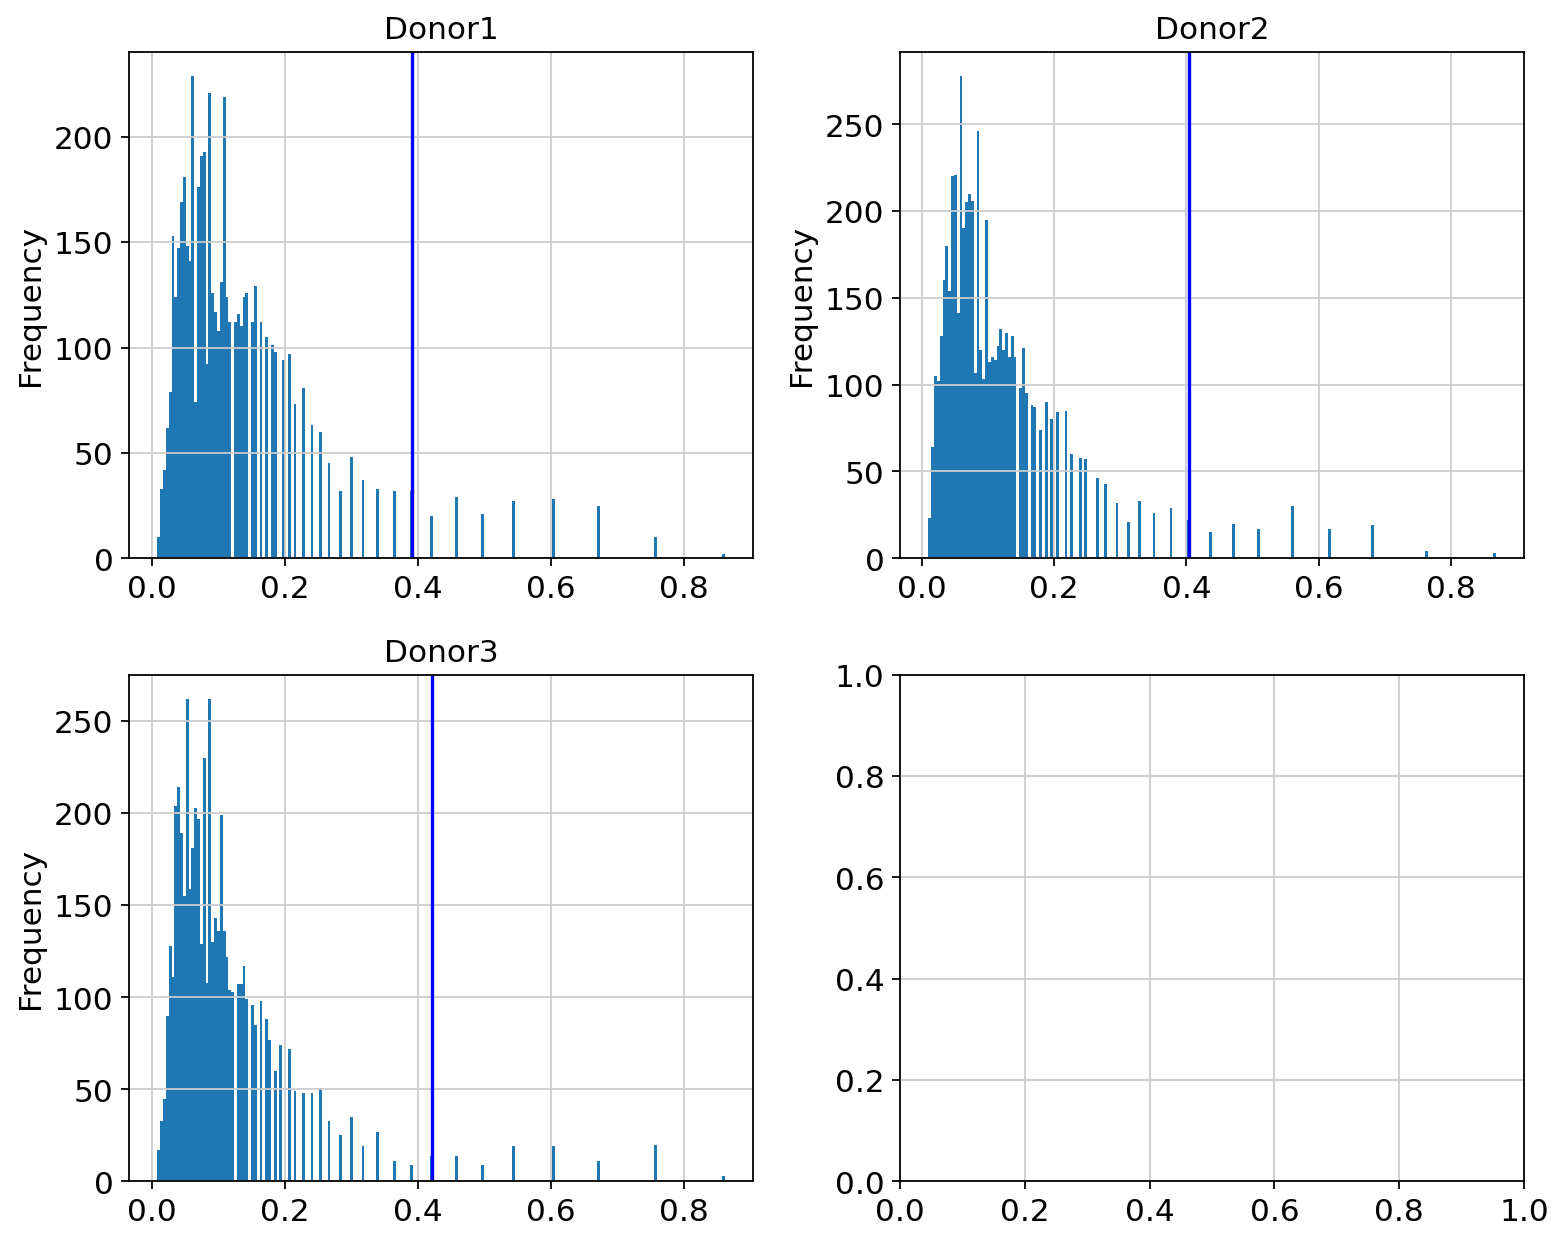

In [9]:
# otherwise just use the n_count for filtering
ncol = 2
nrow = int(np.ceil(len(Donor_unique)/ncol))
fig, ax = plt.subplots(nrow,ncol, figsize=(10,8))
for i in range(len(Donor_unique)):
    print(Donor_unique[i]+': Number of doublets = ', str(np.sum(predicted_db[i])))
    colidx = i%ncol
    rowidx = np.floor(i/ncol).astype(int)
    pd.DataFrame(db_scores[i]).plot.hist(bins=200, ax=ax[rowidx][colidx])
    ax[rowidx][colidx].axvline(x=np.sort(db_scores[i])[::-1][np.sum(predicted_db[i])], color='b')
    ax[rowidx][colidx].get_legend().remove()
    ax[rowidx][colidx].set_title(Donor_unique[i])
plt.tight_layout()  

In [10]:
# save the doublet score in adata
adata = adata[Cells,:].copy()
adata.obs['doublet_score'] = db_results['doublet_scores'].values

In [11]:
print(adata.shape)
print('Total # of doublets: '+str(np.sum(db_results['predicted_doublets'])))

(17089, 32738)
Total # of doublets: 382


In [12]:
# then remove doublet cells
adata = adata[~db_results['predicted_doublets'].values,:].copy()

In [13]:
print(adata.shape)
print(adata.obs['Donor'].value_counts().sort_index())

(16707, 32738)
Donor1    5374
Donor2    5894
Donor3    5439
Name: Donor, dtype: int64


# Quality Control

normalizing counts per cell
    finished (0:00:00)


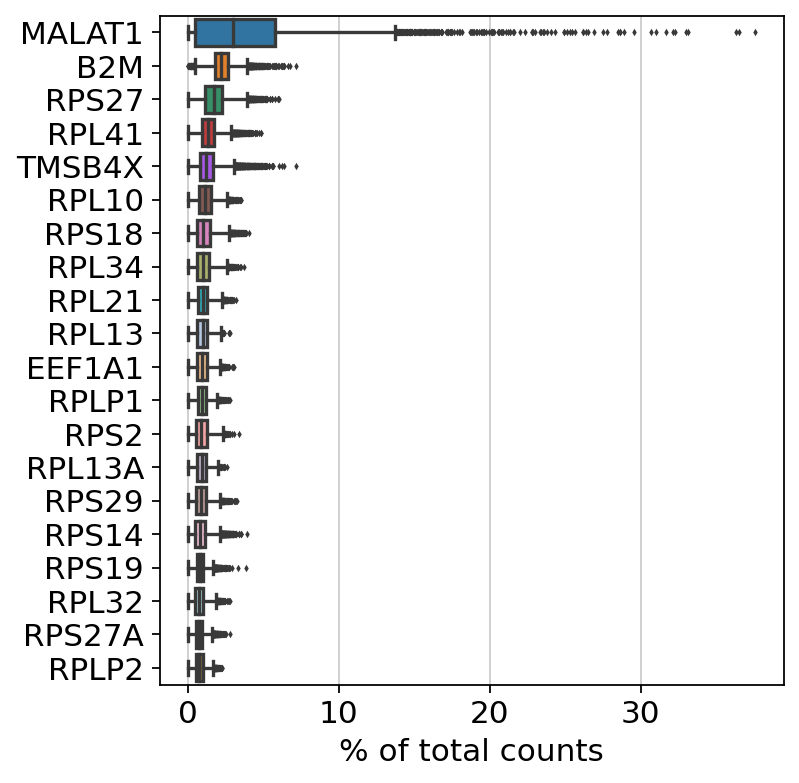

In [14]:
# looks fine here as expected
# All ribosomal protein genes and house keeping genes
sc.pl.highest_expr_genes(adata, n_top=20)

In [15]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') 

In [16]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

In [17]:
adata.obs.head(3)

Barcode   Donor  Vector batch  doublet_score  \
AAACCTGAGCAAATCA-1-0  AAACCTGAGCAAATCA-1  Donor1     0.0     0       0.195745   
AAACCTGAGGTTACCT-1-0  AAACCTGAGGTTACCT-1  Donor1     0.0     0       0.123288   
AAACCTGCAAAGTGCG-1-0  AAACCTGCAAAGTGCG-1  Donor1     0.0     0       0.063265   

                      n_genes_by_counts  log1p_n_genes_by_counts  \
AAACCTGAGCAAATCA-1-0                643                 6.467699   
AAACCTGAGGTTACCT-1-0               1121                 7.022868   
AAACCTGCAAAGTGCG-1-0                979                 6.887553   

                      total_counts  log1p_total_counts  \
AAACCTGAGCAAATCA-1-0        1686.0            7.430707   
AAACCTGAGGTTACCT-1-0        3282.0            8.096513   
AAACCTGCAAAGTGCG-1-0        2287.0            7.735434   

                      pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACCTGAGCAAATCA-1-0                   48.635824                    62.633452   
AAACCTGAGGTTACCT-1-0                   44.028032                    59.018891   
AAACCTGCAAAGTGCG-1-0                   43.725404                    52.557936   

                      pct_counts_in_top_200_genes  \
AAACCTGAGCAAATCA-1-0                    73.724792   
AAACCTGAGGTTACCT-1-0                    68.890920   
AAACCTGCAAAGTGCG-1-0                    62.833406   

                      pct_counts_in_top_500_genes  total_counts_mt  \
AAACCTGAGCAAATCA-1-0                    91.518387             50.0   
AAACCTGAGGTTACCT-1-0                    81.078611             95.0   
AAACCTGCAAAGTGCG-1-0                    79.055531             65.0   

                      log1p_total_counts_mt  pct_counts_mt  
AAACCTGAGCAAATCA-1-0               3.931826       2.965599  
AAACCTGAGGTTACCT-1-0               4.564348       2.894577  
AAACCTGCAAAGTGCG-1-0               4.189655       2.842151

In [18]:
adata.var.head(3)

Ensembl Name   Gene Name     mt  n_cells_by_counts  \
MIR1302-10  ENSG00000243485  MIR1302-10  False                  0   
FAM138A     ENSG00000237613     FAM138A  False                  0   
OR4F5       ENSG00000186092       OR4F5  False                  0   

            mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
MIR1302-10          0.0                0.0                  100.0   
FAM138A             0.0                0.0                  100.0   
OR4F5               0.0                0.0                  100.0   

            total_counts  log1p_total_counts  
MIR1302-10           0.0                 0.0  
FAM138A              0.0                 0.0  
OR4F5                0.0                 0.0

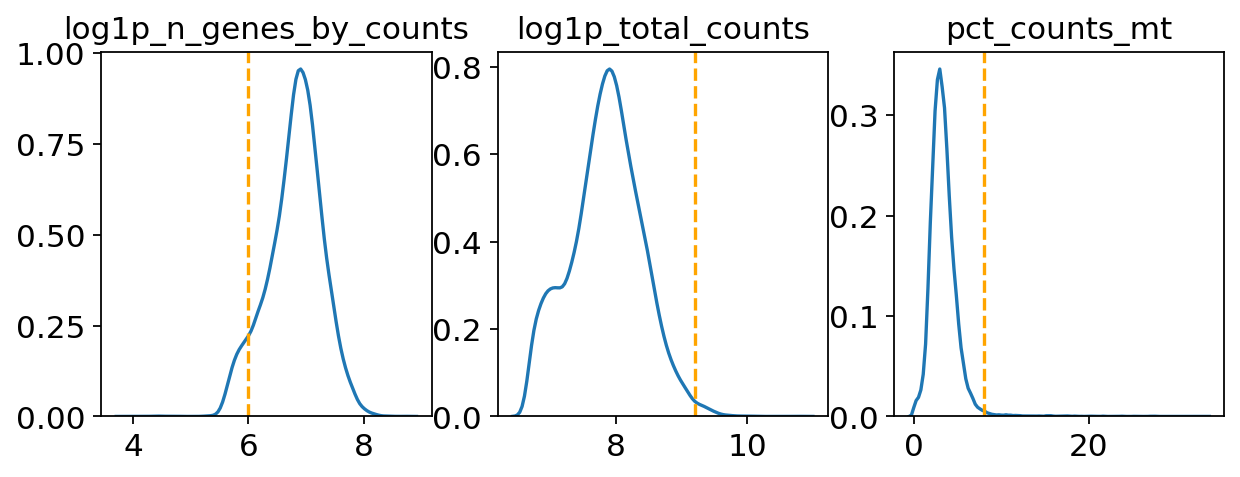

In [19]:
import seaborn as sns
fig,ax = plt.subplots(1,3, figsize=(9,3))
sns.kdeplot(adata.obs['log1p_n_genes_by_counts'], ax=ax[0])
ax[0].grid(False)
ax[0].get_legend().remove()
ax[0].set_title('log1p_n_genes_by_counts')
ax[0].axvline(np.log1p(400), c='orange', linestyle='--')
sns.kdeplot(adata.obs['log1p_total_counts'], ax=ax[1])
ax[1].grid(False)
ax[1].get_legend().remove()
ax[1].set_title('log1p_total_counts')
ax[1].axvline(np.log1p(10000), c='orange', linestyle='--')
sns.kdeplot(adata.obs['pct_counts_mt'], ax=ax[2])
ax[2].grid(False)
ax[2].get_legend().remove()
ax[2].set_title('pct_counts_mt')
ax[2].axvline(8, c='orange', linestyle='--')

In [20]:
# filter cells and genes here based on user preference
sc.pp.filter_cells(adata, min_genes=400)
sc.pp.filter_genes(adata, min_cells=1)

filtered out 1134 cells that have less than 400 genes expressed
filtered out 12229 genes that are detected in less than 1 cells


In [21]:
print(adata.shape)
print(adata.obs['Donor'].value_counts().sort_index())

(15573, 20509)
Donor1    5272
Donor2    5221
Donor3    5080
Name: Donor, dtype: int64


In [22]:
# further QC with high mit percentage and n_counts
adata = adata[(adata.obs['pct_counts_mt'] < 8) & (adata.obs['total_counts'] <= 10000), :].copy()

In [23]:
print(adata.shape)
print(adata.obs['Donor'].value_counts().sort_index())

(15293, 20509)
Donor1    5184
Donor2    5136
Donor3    4973
Name: Donor, dtype: int64


In [24]:
adata.write('./write/PBMC_raw_afterQC.h5ad')

... storing 'Barcode' as categorical
... storing 'Donor' as categorical
... storing 'Gene Name' as categorical


# Normalisation

In [25]:
# normalisation
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [26]:
# log counts
sc.pp.log1p(adata)

In [27]:
adata.raw = adata

In [28]:
adata.write('./write/PBMC_lognorm_afterQC.h5ad')

# Cell Cycle Assignment

In [3]:
adata = sc.read('./write/PBMC_lognorm_afterQC.h5ad')

In [4]:
# Scaling must be done before scoring
sc.pp.scale(adata)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [31]:
cell_cycle_genes = [x.strip().title() for x in open('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Files/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))
cell_cycle_genes = [x.upper() for x in cell_cycle_genes]

97


In [32]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
print('Number of s_genes: '+str(len(s_genes)))
print('Number of g2m_genes: '+str(len(g2m_genes)))
print('Total number of cell cycle genes: '+str(len(cell_cycle_genes)))

Number of s_genes: 43
Number of g2m_genes: 54
Total number of cell cycle genes: 97


In [33]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes, use_raw=False)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    816 total control genes are used. (0:00:02)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    942 total control genes are used. (0:00:02)
-->     'phase', cell cycle phase (adata.obs)


In [34]:
adata.obs['phase'].value_counts().sort_index()

G1     6013
G2M    4474
S      4806
Name: phase, dtype: int64

In [35]:
# save cell cycle assignments
adata.obs[['phase', 'S_score', 'G2M_score']].to_csv('cell_cycle_results.txt')

# RP score calculation

In [22]:
RPgenes = [x for x in adata.var_names if x.startswith('RPS') | x.startswith('RPL')]
print(len(RPgenes))

105


In [23]:
sc.tl.score_genes(adata, gene_list=RPgenes, score_name='RPscore',use_raw=False)

computing score 'RPscore'
    finished: added
    'RPscore', score of gene set (adata.obs).
    990 total control genes are used. (0:00:02)


In [24]:
# save score
adata.obs['RPscore'].to_csv('PBMC_RPscore.csv')

# Select Highly Variable Genes

In [30]:
adata = sc.read('./write/PBMC_lognorm_afterQC.h5ad')

In [32]:
cell_cycle_results = pd.read_csv('cell_cycle_results.txt', index_col=0)
adata.obs = pd.concat([adata.obs, cell_cycle_results], axis=1)

In [62]:
RPscore = pd.read_csv('PBMC_RPscore.csv', index_col=0)
adata.obs['RPscore'] = RPscore

In [34]:
adata.obs.head(3)

Barcode   Donor  Vector batch  doublet_score  \
AAACCTGAGCAAATCA-1-0  AAACCTGAGCAAATCA-1  Donor1     0.0     0       0.195745   
AAACCTGAGGTTACCT-1-0  AAACCTGAGGTTACCT-1  Donor1     0.0     0       0.123288   
AAACCTGCAAAGTGCG-1-0  AAACCTGCAAAGTGCG-1  Donor1     0.0     0       0.063265   

                      n_genes_by_counts  log1p_n_genes_by_counts  \
AAACCTGAGCAAATCA-1-0                643                 6.467699   
AAACCTGAGGTTACCT-1-0               1121                 7.022868   
AAACCTGCAAAGTGCG-1-0                979                 6.887553   

                      total_counts  log1p_total_counts  \
AAACCTGAGCAAATCA-1-0        1686.0            7.430707   
AAACCTGAGGTTACCT-1-0        3282.0            8.096513   
AAACCTGCAAAGTGCG-1-0        2287.0            7.735434   

                      pct_counts_in_top_50_genes  ...  \
AAACCTGAGCAAATCA-1-0                   48.635824  ...   
AAACCTGAGGTTACCT-1-0                   44.028032  ...   
AAACCTGCAAAGTGCG-1-0                   43.725404  ...   

                      pct_counts_in_top_500_genes  total_counts_mt  \
AAACCTGAGCAAATCA-1-0                    91.518387             50.0   
AAACCTGAGGTTACCT-1-0                    81.078611             95.0   
AAACCTGCAAAGTGCG-1-0                    79.055531             65.0   

                      log1p_total_counts_mt  pct_counts_mt  n_genes  n_counts  \
AAACCTGAGCAAATCA-1-0               3.931826       2.965599      643    1686.0   
AAACCTGAGGTTACCT-1-0               4.564348       2.894577     1121    3282.0   
AAACCTGCAAAGTGCG-1-0               4.189655       2.842151      979    2287.0   

                      phase   S_score G2M_score   RPscore  
AAACCTGAGCAAATCA-1-0    G2M -0.018118  0.036294  0.134132  
AAACCTGAGGTTACCT-1-0      S  0.114588 -0.064109  0.355887  
AAACCTGCAAAGTGCG-1-0     G1 -0.211047 -0.169469 -1.274222  

[3 rows x 22 columns]

In [35]:
# find highly variable genes
# parameters are mainly selected depends on user preference
sc.pp.highly_variable_genes(
    adata, min_mean=0.02, max_mean=3, min_disp=0.5, batch_key='batch', inplace=True)

extracting highly variable genes


... storing 'phase' as categorical


    finished (0:00:14)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


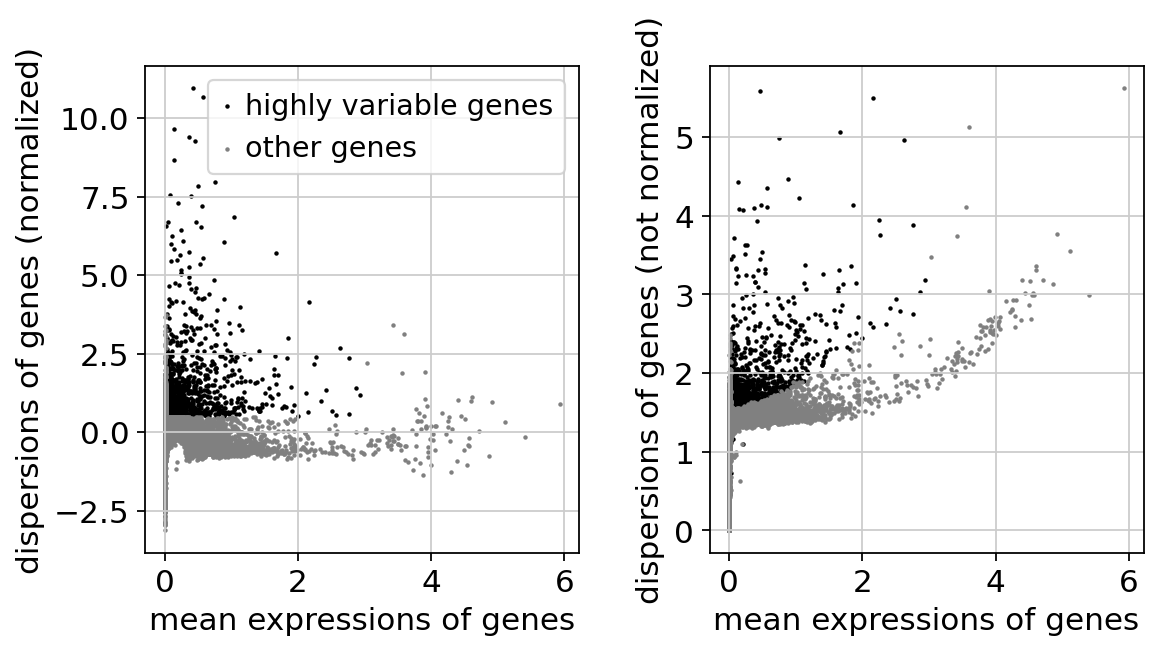

In [36]:
sc.pl.highly_variable_genes(adata)

In [37]:
print(np.sum(adata.var.highly_variable))

1527


In [38]:
adata = adata[:, adata.var.highly_variable]

In [39]:
adata.shape

(15293, 1527)

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'n_genes_by_counts'])

In [41]:
# scale for pca
sc.pp.scale(adata)

In [42]:
print(adata.shape)
print(adata.obs['Donor'].value_counts().sort_index())

(15293, 1527)
Donor1    5184
Donor2    5136
Donor3    4973
Name: Donor, dtype: int64


# Visualisation

In [29]:
# first try pca
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


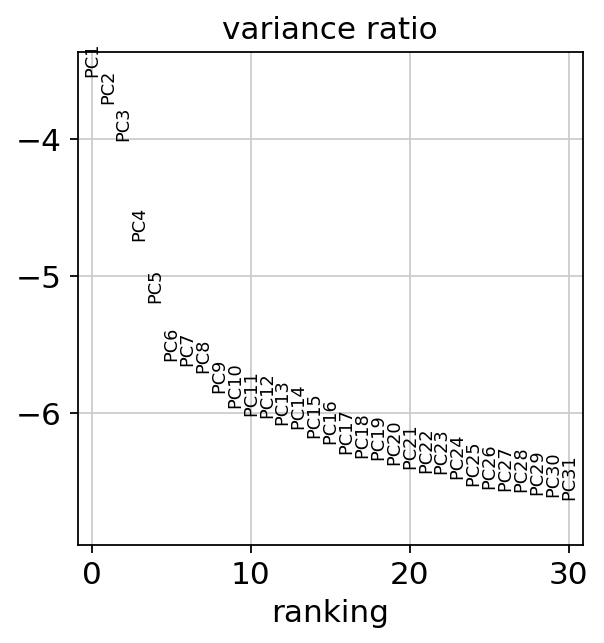

In [30]:
sc.pl.pca_variance_ratio(adata, log=True)

In [31]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.tsne(adata)
sc.tl.draw_graph(adata)
sc.tl.diffmap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:02:01)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:02:20)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.99776375 0.99602467 0.9891175  0.97871125
     0.9690414  0.9672695  0.9645781  0.9518191  0.9458371  0.94479734
     0.94283223 0.9392736  0.93792313]
    finished: added
    'X_diffmap', diffmap coordinates

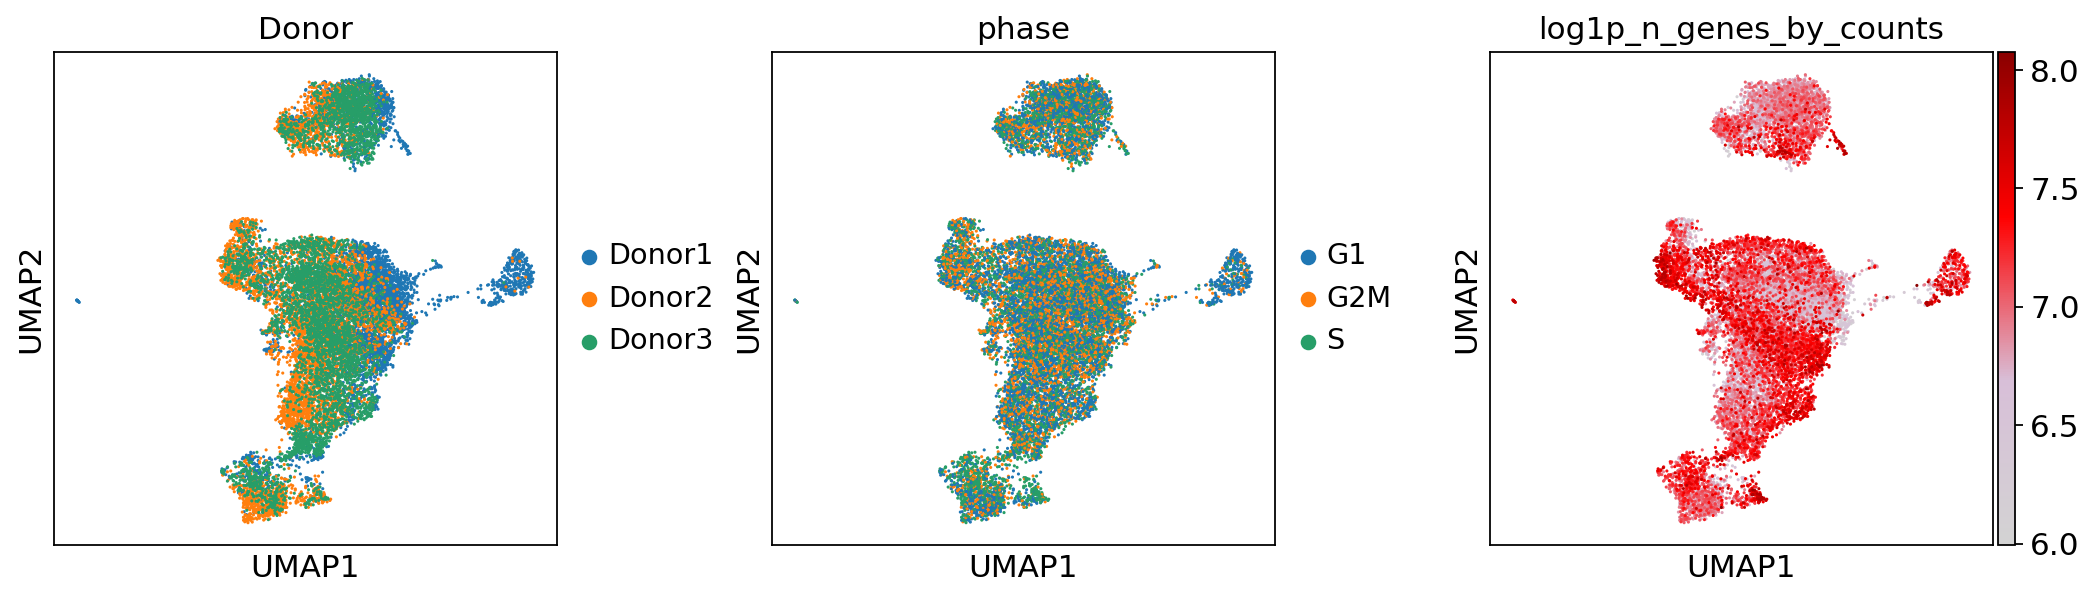

In [32]:
sc.pl.umap(adata, color=['Donor', 'phase', 'log1p_n_genes_by_counts'], color_map=cmap, wspace=0.3)

In [33]:
adata.shape

(15293, 1527)

In [63]:
adata.write('./write/PBMC_processed.h5ad')

# Look at Vectors

In [3]:
adata = sc.read('./write/PBMC_processed.h5ad')

In [5]:
np.sum(adata.obs['Vector']>0)

13

Good that most of the cells are vec - 

# Cell Type Assignment PBMC68K

In [2]:
adata = sc.read('./write/PBMC_processed.h5ad')

In [39]:
Proj_results = pd.read_csv('Proj_PBMC_onto_PBMC68K_results.csv', index_col=0)

In [40]:
Proj_results.head(3)

MinDist  MedianDist   MaxDist        SD  \
AAACCTGAGCAAATCA-1-0  3.103259    3.527457  3.597236  0.140980   
AAACCTGAGGTTACCT-1-0  5.770245    6.692144  6.806241  0.314530   
AAACCTGCAAAGTGCG-1-0  7.298321    8.996329  9.353425  0.530901   

                                           PBMC_CT  
AAACCTGAGCAAATCA-1-0  CD8+/CD45RA+ Naive Cytotoxic  
AAACCTGAGGTTACCT-1-0    CD4+/CD45RA+/CD25- Naive T  
AAACCTGCAAAGTGCG-1-0                CD14+ Monocyte

In [41]:
adata.obs['Proj_PBMC68K'] = Proj_results['PBMC_CT'].values

... storing 'Proj_PBMC68K' as categorical


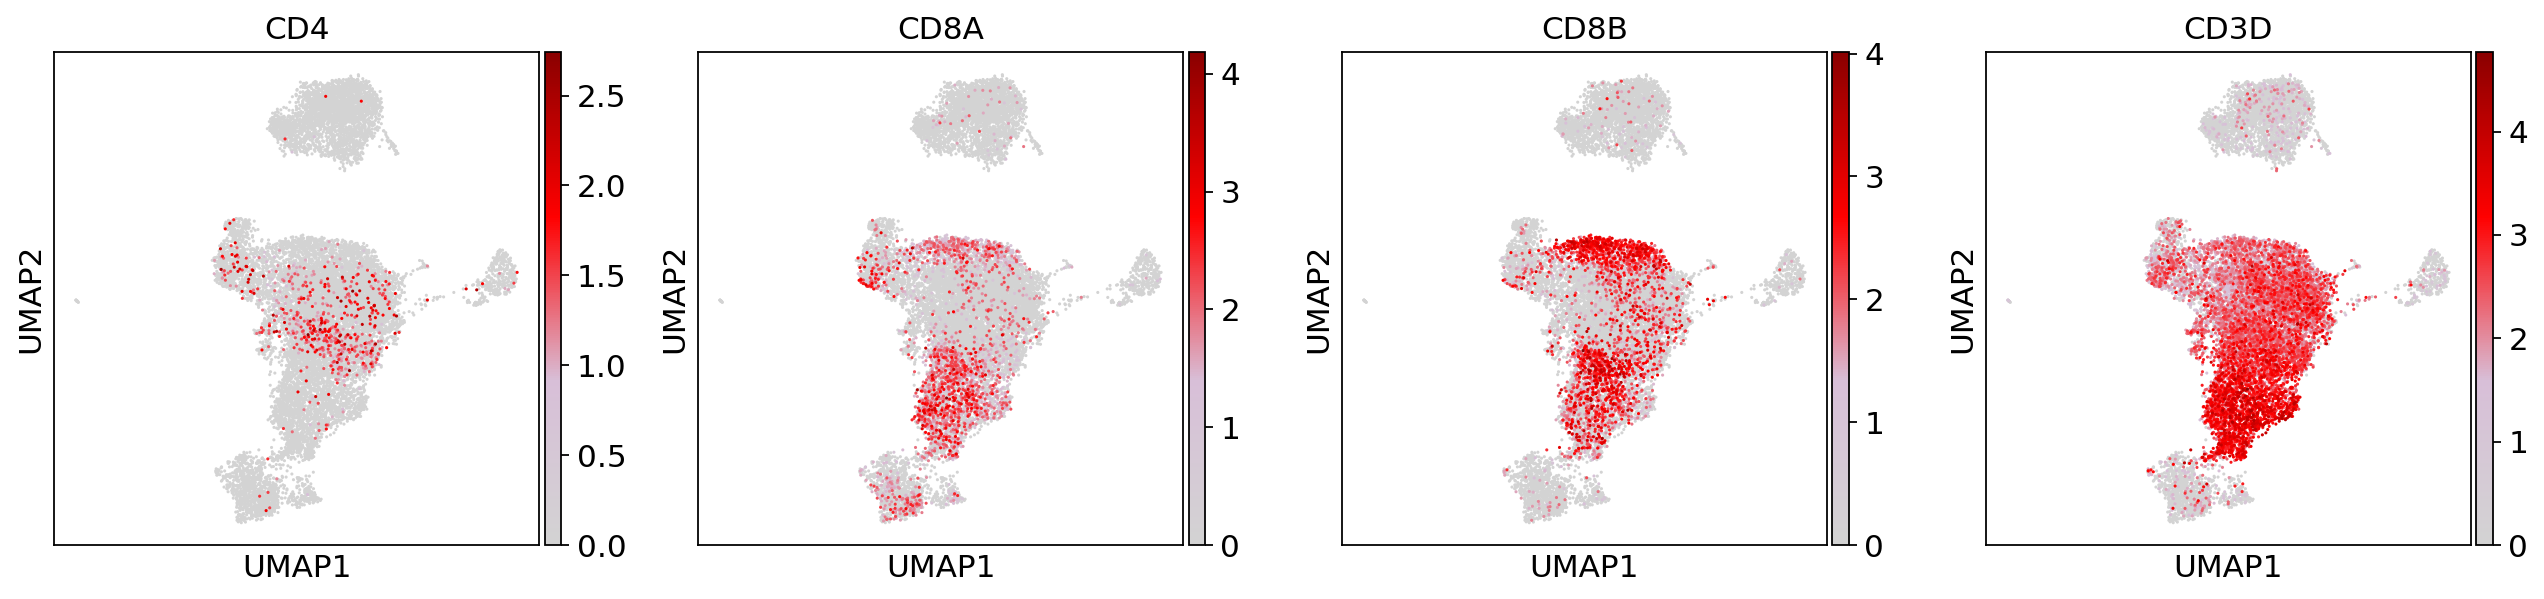

In [42]:
sc.pl.umap(adata, color=['CD4', 'CD8A', 'CD8B', 'CD3D'], color_map=cmap)

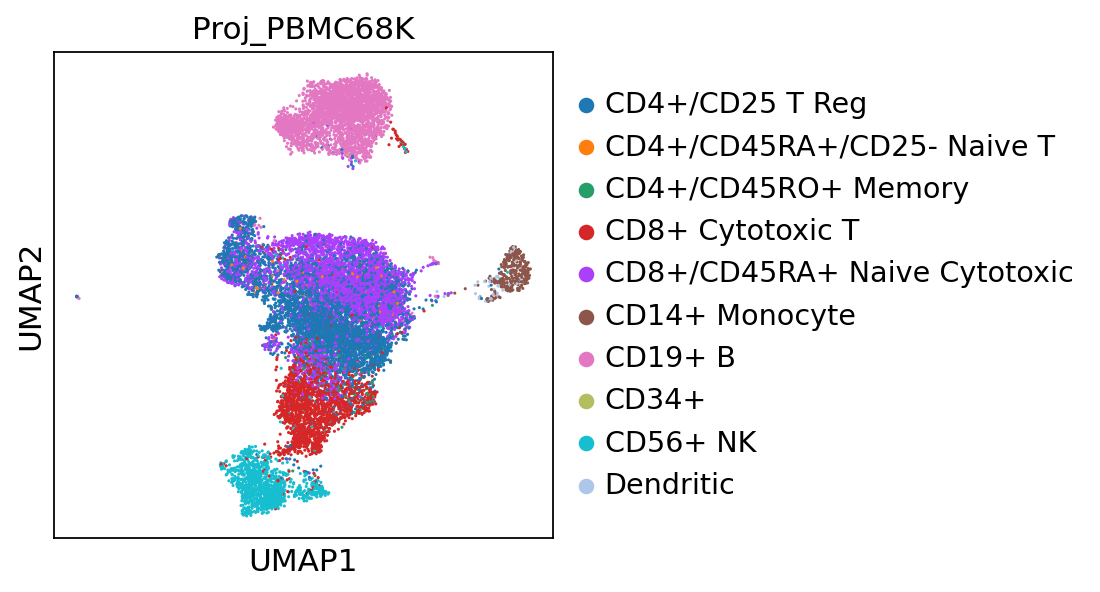

In [43]:
sc.pl.umap(adata, color='Proj_PBMC68K')

In [3]:
adata.obs['Proj_PBMC68K'].value_counts()

CD4+/CD25 T Reg                 4685
CD8+/CD45RA+ Naive Cytotoxic    4110
CD19+ B                         2905
CD8+ Cytotoxic T                1874
CD56+ NK                        1150
CD14+ Monocyte                   292
CD4+/CD45RO+ Memory              131
CD4+/CD45RA+/CD25- Naive T        96
Dendritic                         49
CD34+                              1
Name: Proj_PBMC68K, dtype: int64

In [5]:
CTrename = {
    'CD4+/CD25 T Reg': 'T cells',
    'CD8+/CD45RA+ Naive Cytotoxic': 'T cells',
    'CD8+ Cytotoxic T': 'T cells',
    'CD4+/CD45RO+ Memory': 'T cells',
    'CD4+/CD45RA+/CD25- Naive T': 'T cells'
}

In [7]:
adata.obs['Proj_PBMC68K_new'] = [CTrename[x] if x in CTrename.keys() else x for x in adata.obs['Proj_PBMC68K']]

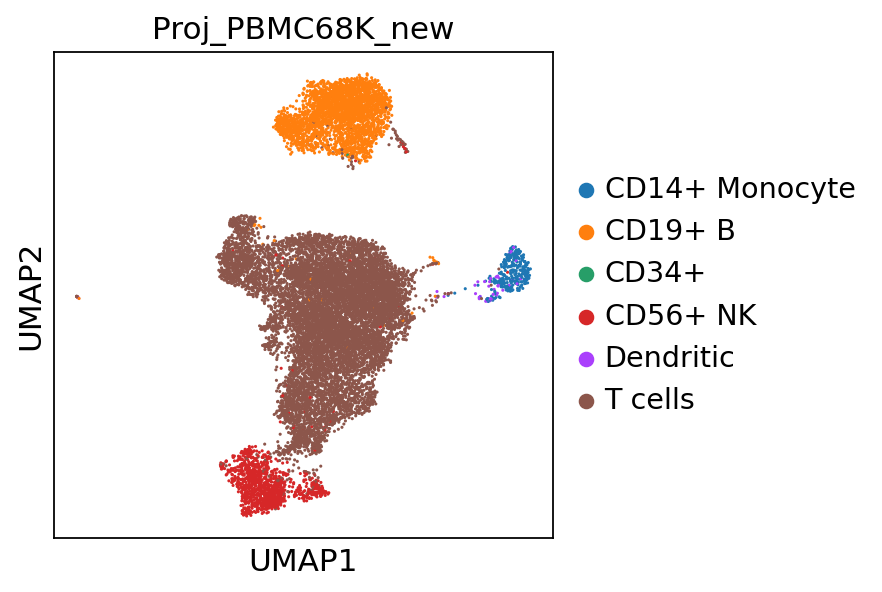

In [10]:
sc.pl.umap(adata, color='Proj_PBMC68K_new', save='_PBMC_Proj_PBMC68K_new.pdf')

In [9]:
adata.write('./write/PBMC_processed.h5ad')

In [50]:
adata.shape

(15293, 1527)

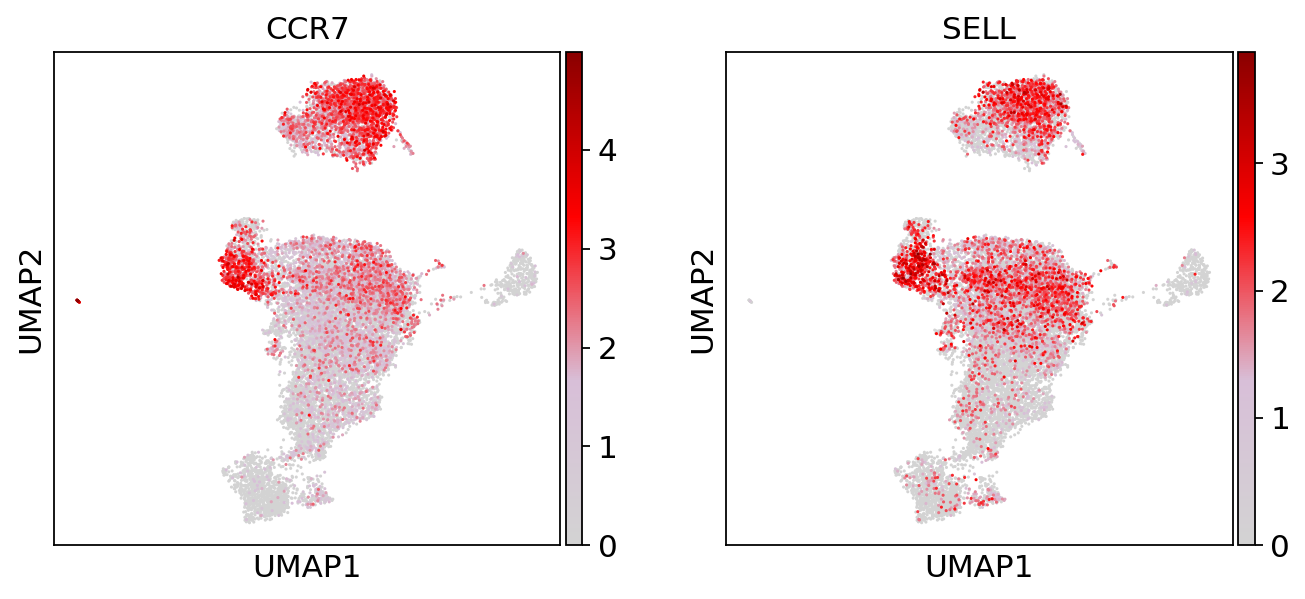

In [4]:
sc.pl.umap(adata, color=['CCR7', 'SELL'], color_map=cmap)

# Clustering

In [103]:
adata = sc.read('./write/PBMC_processed.h5ad')

In [33]:
import louvain
def get_igraph_from_adjacency(adjacency, directed=None):
    """Get igraph graph from adjacency matrix."""
    import igraph as ig

    sources, targets = adjacency.nonzero()
    weights = adjacency[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=directed)
    g.add_vertices(adjacency.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))
    try:
        g.es['weight'] = weights
    except:
        pass
    if g.vcount() != adjacency.shape[0]:
        logg.warning(
            f'The constructed graph has only {g.vcount()} nodes. '
            'Your adjacency matrix contained redundant nodes.'
        )
    return g

def _choose_graph(adata, obsp, neighbors_key):
    """Choose connectivities from neighbbors or another obsp column"""
    if obsp is not None and neighbors_key is not None:
        raise ValueError(
            'You can\'t specify both obsp, neighbors_key. ' 'Please select only one.'
        )

    if obsp is not None:
        return adata.obsp[obsp]
    else:
        neighbors = NeighborsView(adata, neighbors_key)
        if 'connectivities' not in neighbors:
            raise ValueError(
                'You need to run `pp.neighbors` first '
                'to compute a neighborhood graph.'
            )
        return neighbors['connectivities']

In [87]:
adjacency = _choose_graph(adata, 'connectivities', None)
g = get_igraph_from_adjacency(adjacency, directed=False)

In [90]:
modusave = {}
for i in np.arange(0.1, 2, 0.1):
    i = round(i,1)
    print(i)
    partition_type = louvain.RBConfigurationVertexPartition
    partition_kwargs = dict()
    louvain.set_rng_seed(0)
    partition_kwargs["resolution_parameter"] = i
    part = louvain.find_partition(
                    g, partition_type,
                    **partition_kwargs,
                )
    modularity = g.modularity(part.membership)
    modusave['m'+str(i)] = modularity 

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9


In [91]:
modusave

{'m0.1': 0.42748955114353054,
 'm0.2': 0.6370603376704188,
 'm0.3': 0.6374579224759344,
 'm0.4': 0.7138133894614982,
 'm0.5': 0.7150182013445445,
 'm0.6': 0.7142515943854665,
 'm0.7': 0.7357076074646953,
 'm0.8': 0.7365705497572466,
 'm0.9': 0.7390478062803046,
 'm1.0': 0.7364507695540804,
 'm1.1': 0.7349074551669359,
 'm1.2': 0.7351529478358403,
 'm1.3': 0.7317183717671399,
 'm1.4': 0.7309207989716521,
 'm1.5': 0.728624935594533,
 'm1.6': 0.7213158791858962,
 'm1.7': 0.7191400160982524,
 'm1.8': 0.7153419108732136,
 'm1.9': 0.7146995705854956}

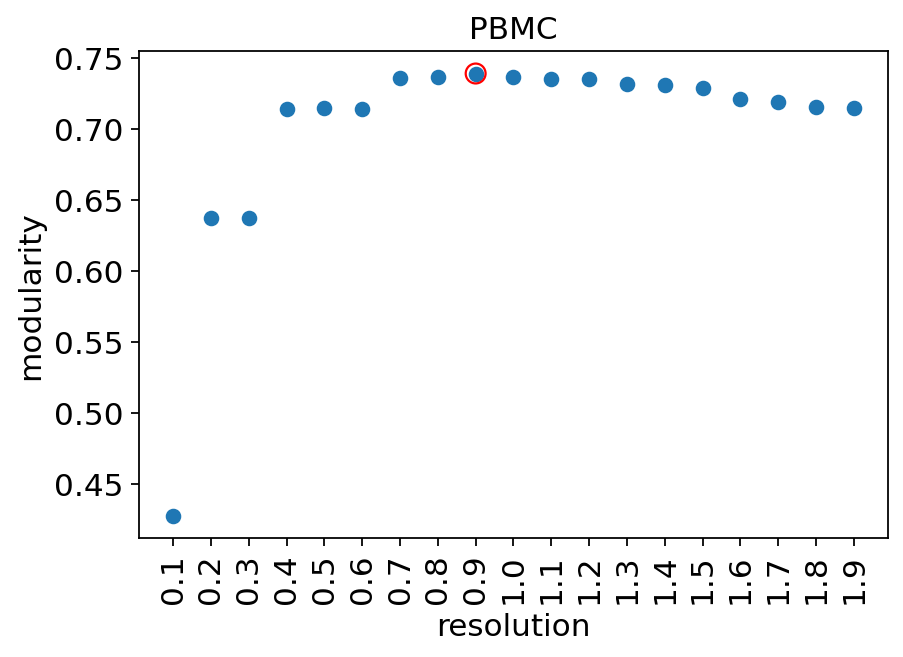

In [93]:
fig, ax = plt.subplots(figsize = (6,4))
x = np.arange(0.1, 2, 0.1)
y = list(modusave.values())
ax.scatter(x, y)
ax.grid(False)
ax.set_xlabel('resolution')
ax.set_ylabel('modularity')
ax.set_title('PBMC')
plt.xticks(x, rotation=90)
maxidx = y.index(max(y))
ax.scatter(x[maxidx], y[maxidx], s=80,facecolors='none', edgecolors='r')

In [99]:
sc.tl.louvain(adata, resolution = 0.4,  key_added='louvain_v1')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain_v1', the cluster labels (adata.obs, categorical) (0:00:01)


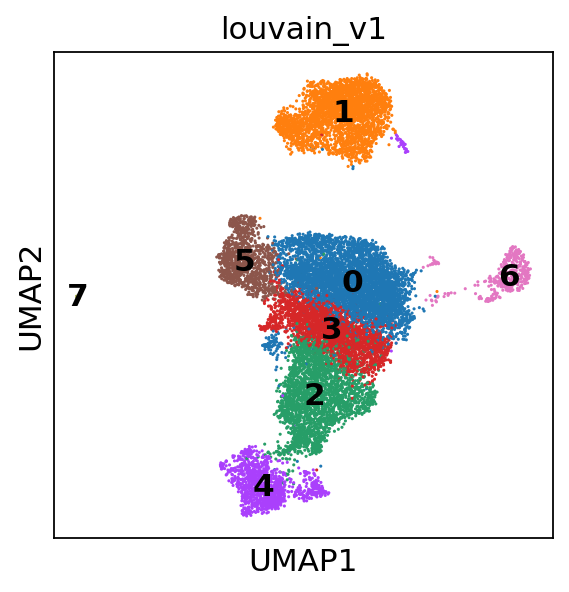

In [100]:
sc.pl.umap(adata, color='louvain_v1', legend_loc='on data')

In [5]:
RN_cluster = {'1': '1',
             '6': '2',
             '4': '3',
             '5': '4',
             '0': '5',
             '3': '6',
             '2': '7',
             '7': '8'}

In [6]:
adata.obs['louvain_v1'] = ['L1_'+RN_cluster[x] for x in adata.obs['louvain_v1']]

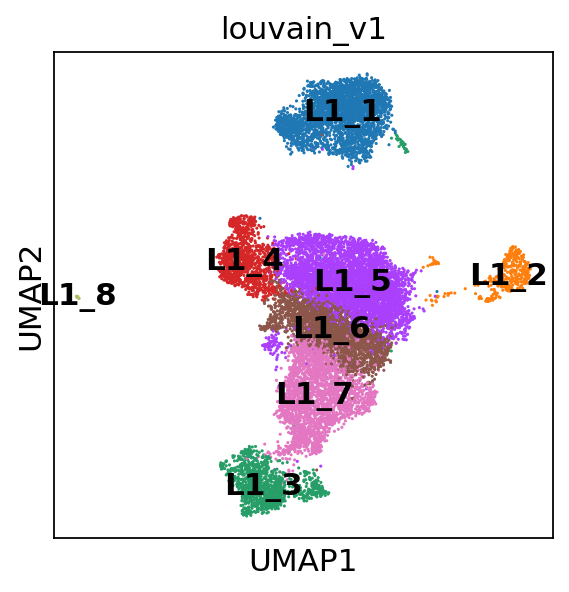

In [11]:
sc.pl.umap(adata, color='louvain_v1', legend_loc='on data', save='_PBMC_louvain_v1.pdf')

In [101]:
sc.tl.rank_genes_groups(adata, groupby='louvain_v1', n_genes=adata.raw.shape[1], key_added='DE_louvain_v1', method='t-test')

ranking genes
    finished: added to `.uns['DE_louvain_v1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


In [102]:
del adata.uns['dendrogram_louvain_v1']

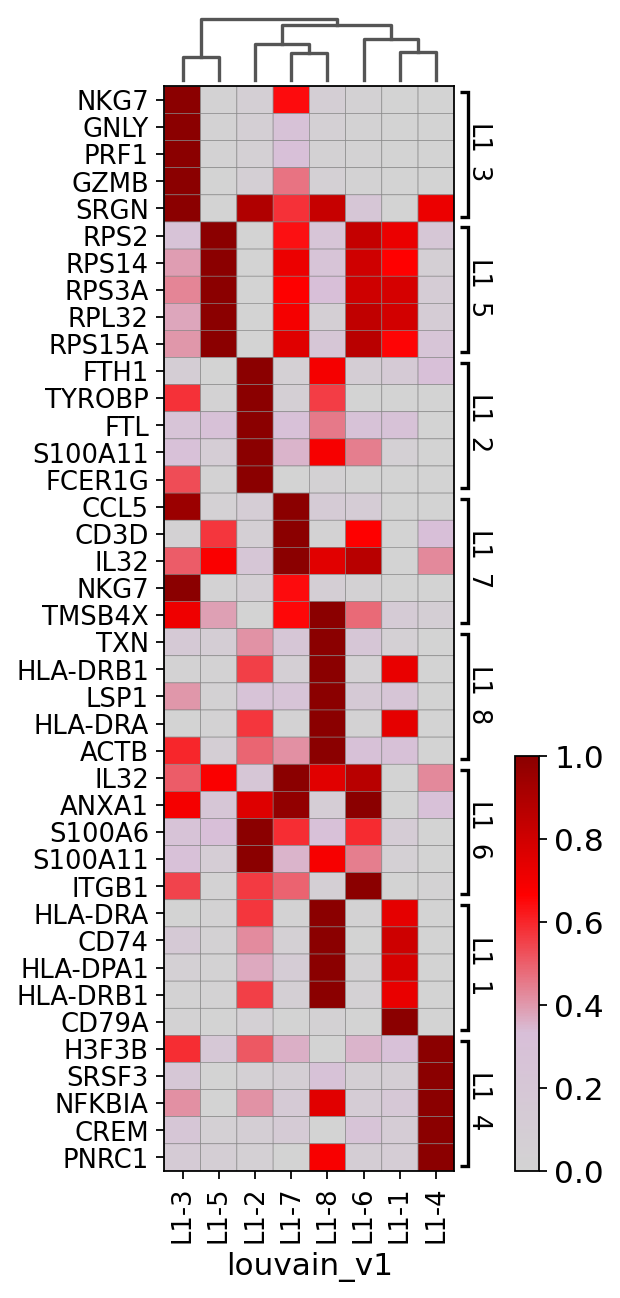

In [104]:
sc.pl.rank_genes_groups_matrixplot(adata, key='DE_louvain_v1',groupby='louvain_v1', n_genes=5, cmap=cmap, standard_scale='var',swap_axes=True, save='_PBMC_leiden_v1_top5G.pdf')

In [2]:
adata = sc.read('./write/PBMC_processed.h5ad')

Index(['L1_1', 'L1_2', 'L1_3', 'L1_4', 'L1_5', 'L1_6', 'L1_7', 'L1_8'], dtype='object')
0
(15293, 1527)
(15293, 20509)
upRegulated gene: 654
downRegulated gene: 1400


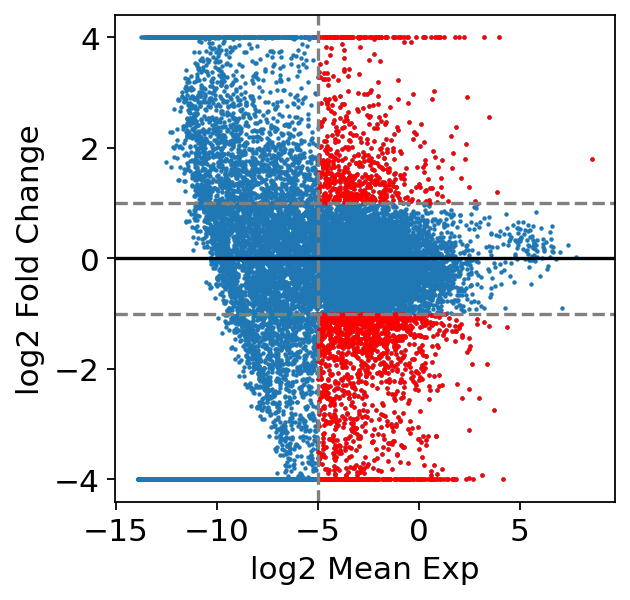

1
(15293, 1527)
(15293, 20509)
upRegulated gene: 1578
downRegulated gene: 2330


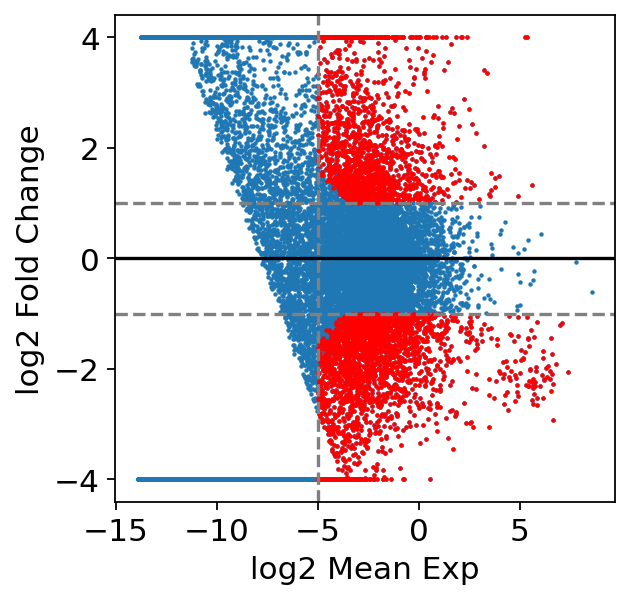

2
(15293, 1527)
(15293, 20509)
upRegulated gene: 1152
downRegulated gene: 677


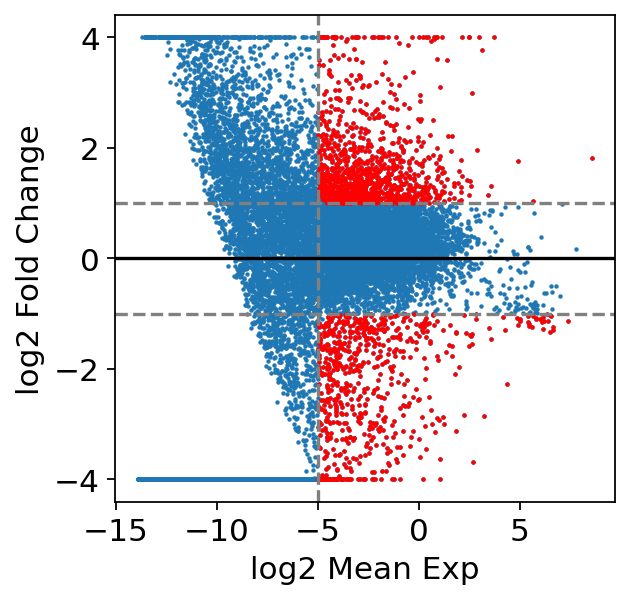

3
(15293, 1527)
(15293, 20509)
upRegulated gene: 3330
downRegulated gene: 1269


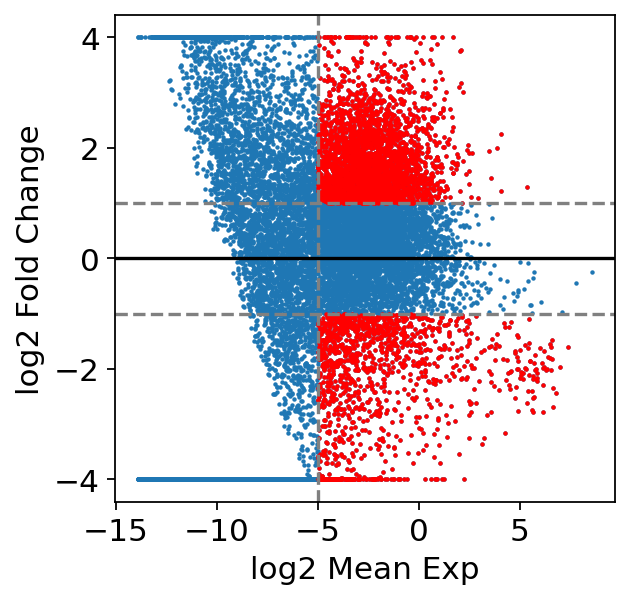

4
(15293, 1527)
(15293, 20509)
upRegulated gene: 98
downRegulated gene: 2753


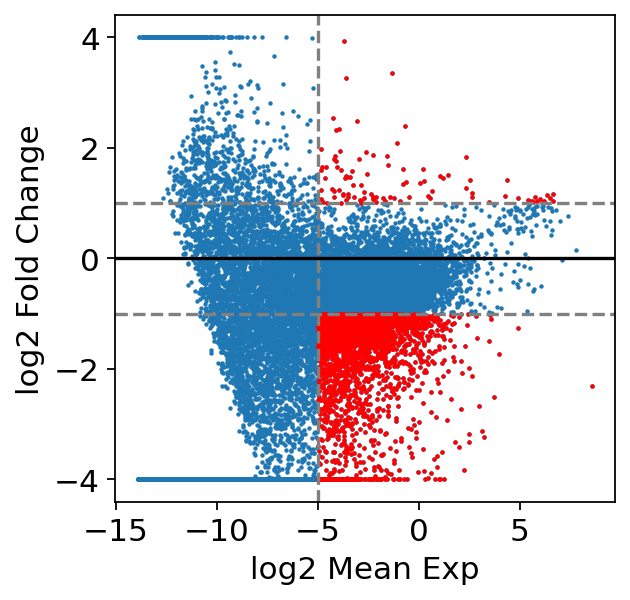

5
(15293, 1527)
(15293, 20509)
upRegulated gene: 215
downRegulated gene: 623


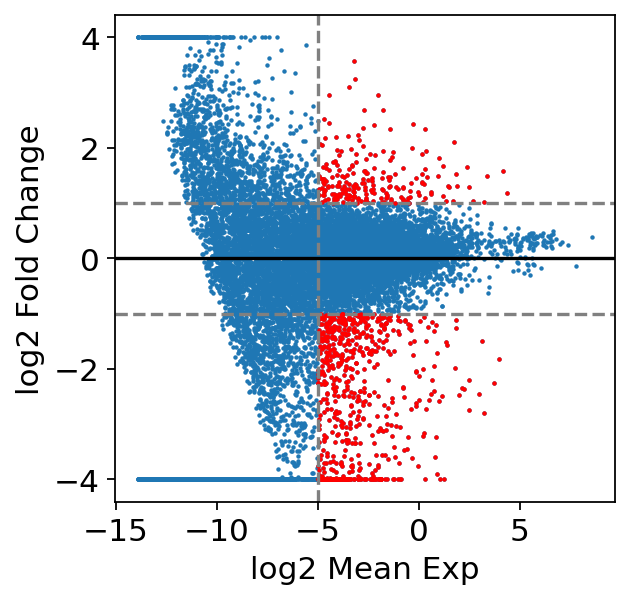

6
(15293, 1527)
(15293, 20509)
upRegulated gene: 374
downRegulated gene: 649


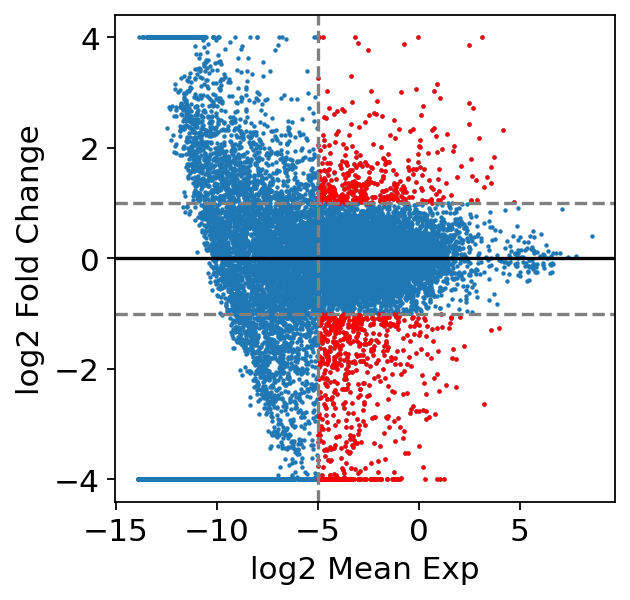

7
(15293, 1527)
(15293, 20509)
upRegulated gene: 296
downRegulated gene: 4137


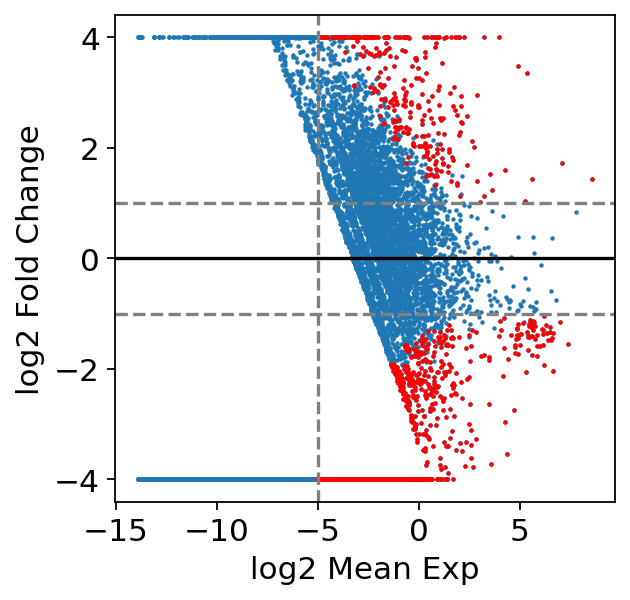

In [6]:
import smqpp
cat = adata.obs['louvain_v1'].cat.categories
print(cat)
for x in range(len(cat)):
    print(x)
    upG, downG, tableG = smqpp.plot_ma(adata, 'DE_louvain_v1',cidx=int(x), padj_cutoff=0.05, logFC_cutoff=1, exp_cutoff=-5)
    np.savetxt('./DEres/PBMC_louvain_v1/'+cat[x]+'vsAll_upG.txt', upG, delimiter='\t', fmt='%s')
    np.savetxt('./DEres/PBMC_louvain_v1/'+cat[x]+'vsAll_downG.txt', downG, delimiter='\t', fmt='%s')
    tableG.to_csv('./DEres/PBMC_louvain_v1/'+cat[x]+'vsAll_table.csv')

In [10]:
adata.write('./write/PBMC_processed.h5ad')

# Cell Sig

In [8]:
import smqpp
adata = sc.read('./write/PBMC_processed.h5ad')
temp = adata.raw 
del adata.raw
import anndata
adata.raw = anndata.AnnData(X=temp.X.toarray(), var=temp.var, obs=adata.obs)
del temp

c2 all curated database

In [7]:
with open('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Files/Pathway_DB/c2.all.v7.1.symbols.gmt') as f:
    DBcont = f.readlines()
DBcont = np.array(DBcont)
DBcont = DBcont[[(('BIOCARTA_' in x) | ('REACTOME_' in x) | ('PID_' in x) | ('KEGG_' in x) | ('HALLMARK_' in x)) for x in DBcont]]

In [9]:
c2DBres = smqpp.pathway_score_cal(adata, DBcont)
c2DB = anndata.AnnData(c2DBres, obs=adata.obs,  obsm=adata.obsm)
c2DB.var_names = [x[0:40] for x in c2DBres.columns]
c2DB.var_names_make_unique()
sc.tl.rank_genes_groups(c2DB, 'louvain_v1', n_genes=c2DB.shape[1], key_added='DE_louvain_v1', method='t-test')

ranking genes
    finished: added to `.uns['DE_louvain_v1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


Index(['L1_1', 'L1_2', 'L1_3', 'L1_4', 'L1_5', 'L1_6', 'L1_7', 'L1_8'], dtype='object')
0
(15293, 2015)
(15293, 2015)
upRegulated gene: 46
downRegulated gene: 177


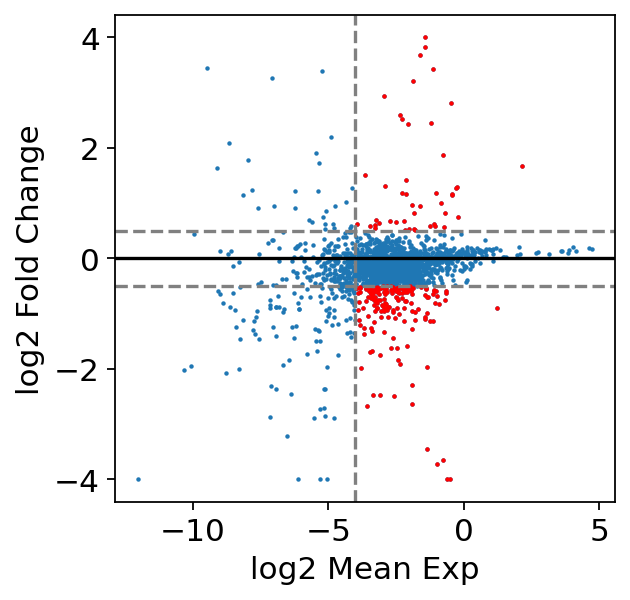

1
(15293, 2015)
(15293, 2015)
upRegulated gene: 719
downRegulated gene: 83


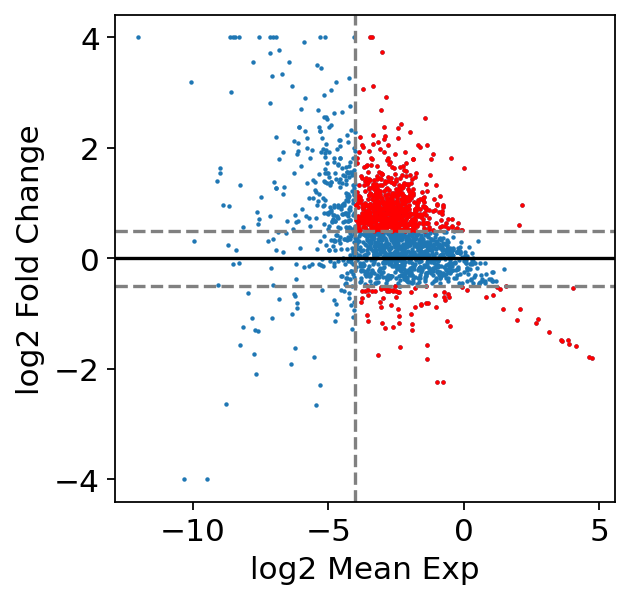

2
(15293, 2015)
(15293, 2015)
upRegulated gene: 533
downRegulated gene: 23


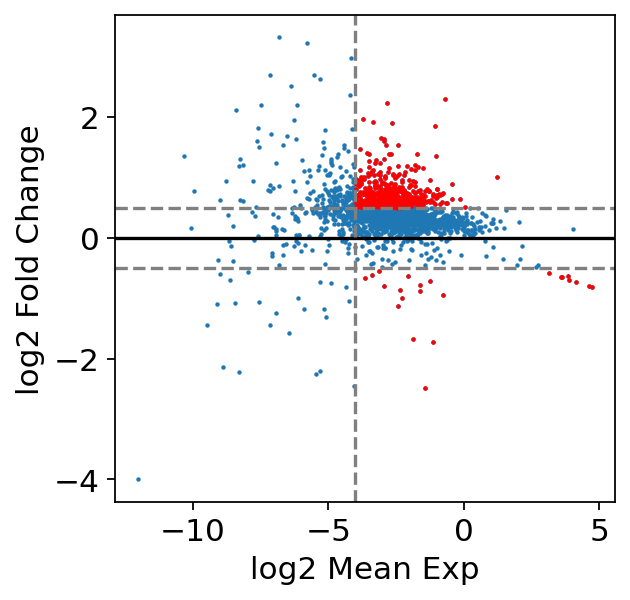

3
(15293, 2015)
(15293, 2015)
upRegulated gene: 731
downRegulated gene: 58


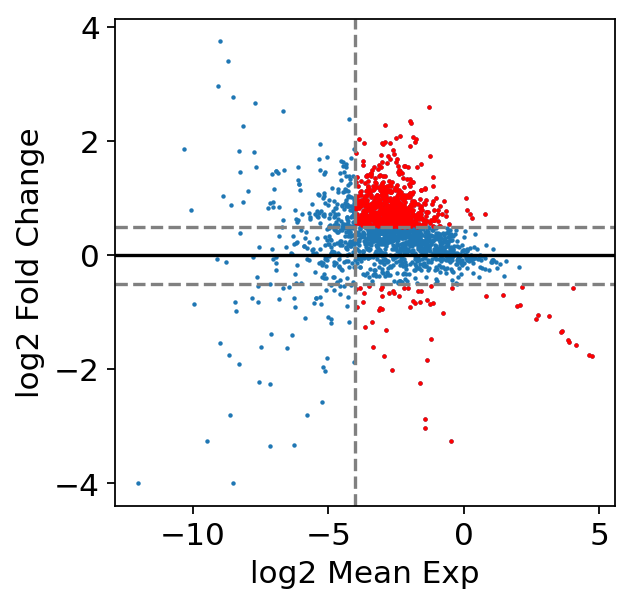

4
(15293, 2015)
(15293, 2015)
upRegulated gene: 7
downRegulated gene: 874


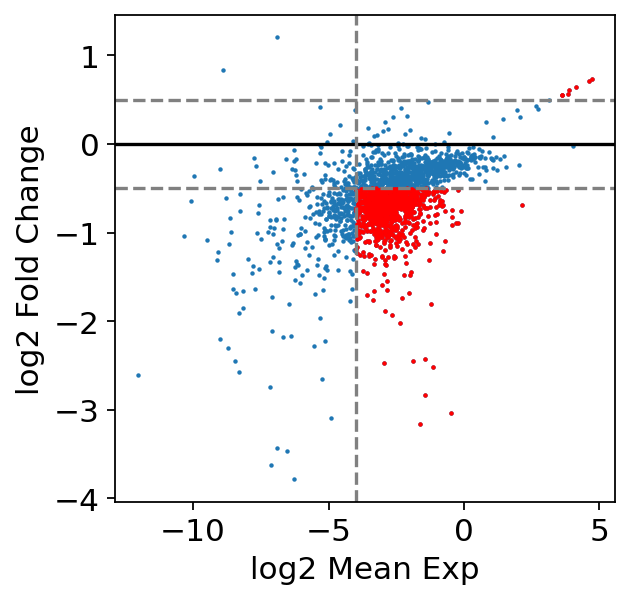

5
(15293, 2015)
(15293, 2015)
upRegulated gene: 40
downRegulated gene: 18


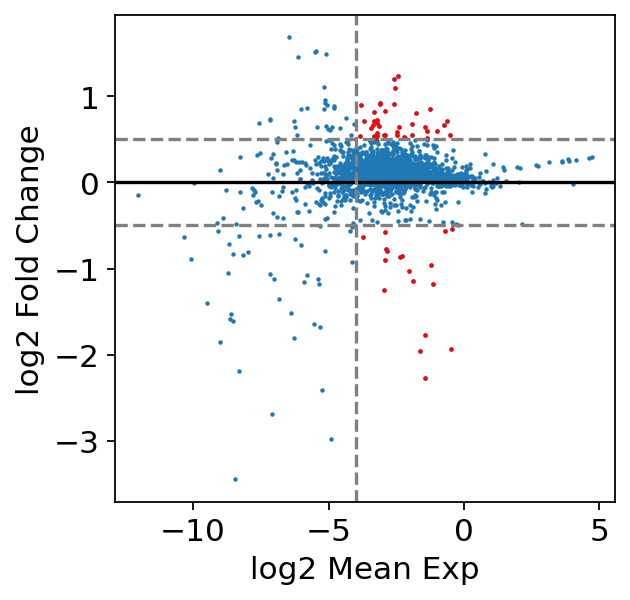

6
(15293, 2015)
(15293, 2015)
upRegulated gene: 71
downRegulated gene: 16


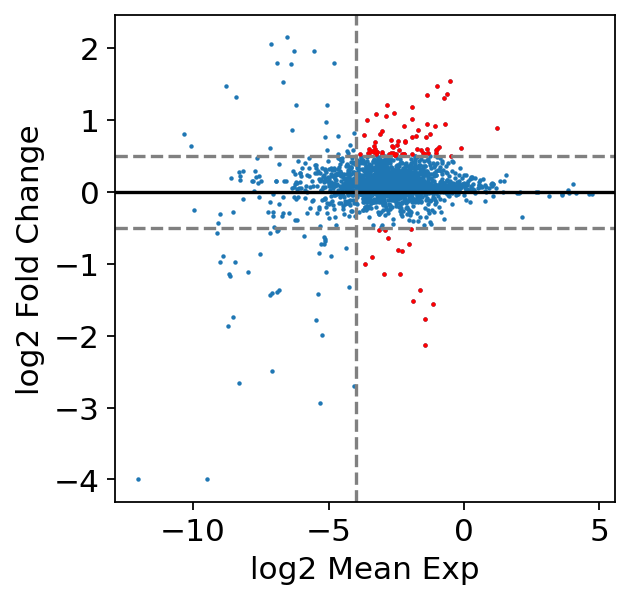

7
(15293, 2015)
(15293, 2015)
upRegulated gene: 533
downRegulated gene: 61


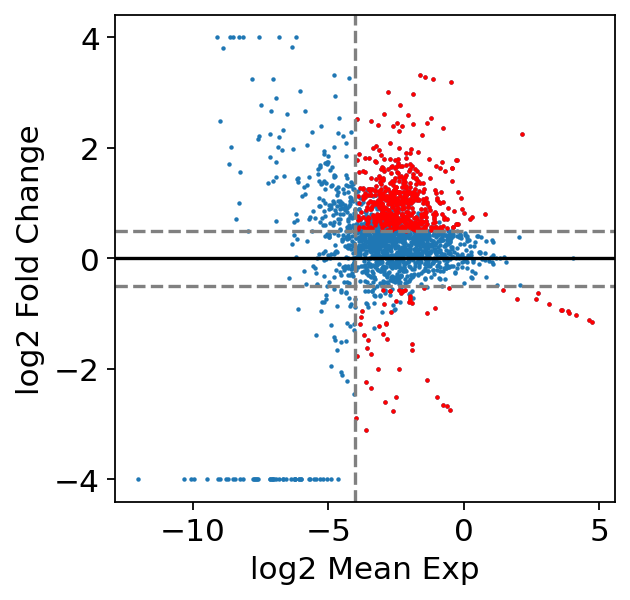

In [10]:
cat = c2DB.obs['louvain_v1'].cat.categories
print(cat)
c2DB.raw= c2DB
for x in range(len(cat)):
    print(x)
    upG, downG, tableG = smqpp.plot_ma(c2DB, 'DE_louvain_v1',cidx=int(x), padj_cutoff=0.05, logFC_cutoff=0.5, exp_cutoff=-4)
    np.savetxt('Pathway/PBMC_louvain_v1_c2DB/'+cat[x]+'vsAll_upG.txt', upG, delimiter='\t', fmt='%s')
    np.savetxt('Pathway/PBMC_louvain_v1_c2DB/'+cat[x]+'vsAll_downG.txt', downG, delimiter='\t', fmt='%s')
    tableG.to_csv('Pathway/PBMC_louvain_v1_c2DB/'+cat[x]+'vsAll_table.csv')

In [45]:
c2DB = sc.read('./write/PBMC_Tcells_c2DB.h5ad')

In [46]:
import os
import re
GL2plot = {}
files = np.array(os.listdir('./Pathway/PBMC_louvain_v1_c2DB/'))
files = files[['upG' in x for x in files]]
print(files)
for f in files:
    cl = re.search('L1_\d+' , f)[0]
    GL2plot[cl] = np.genfromtxt('./Pathway/PBMC_louvain_v1_c2DB/'+f, dtype=str, delimiter='\t')[0:5]

['L1_4vsAll_upG.txt' 'L1_8vsAll_upG.txt' 'L1_1vsAll_upG.txt'
 'L1_2vsAll_upG.txt' 'L1_6vsAll_upG.txt' 'L1_3vsAll_upG.txt'
 'L1_5vsAll_upG.txt' 'L1_7vsAll_upG.txt']


In [47]:
from collections import OrderedDict
ordered = OrderedDict()
for k in c2DB.obs['louvain_v1'].cat.categories:
    ordered[k] = GL2plot[k]

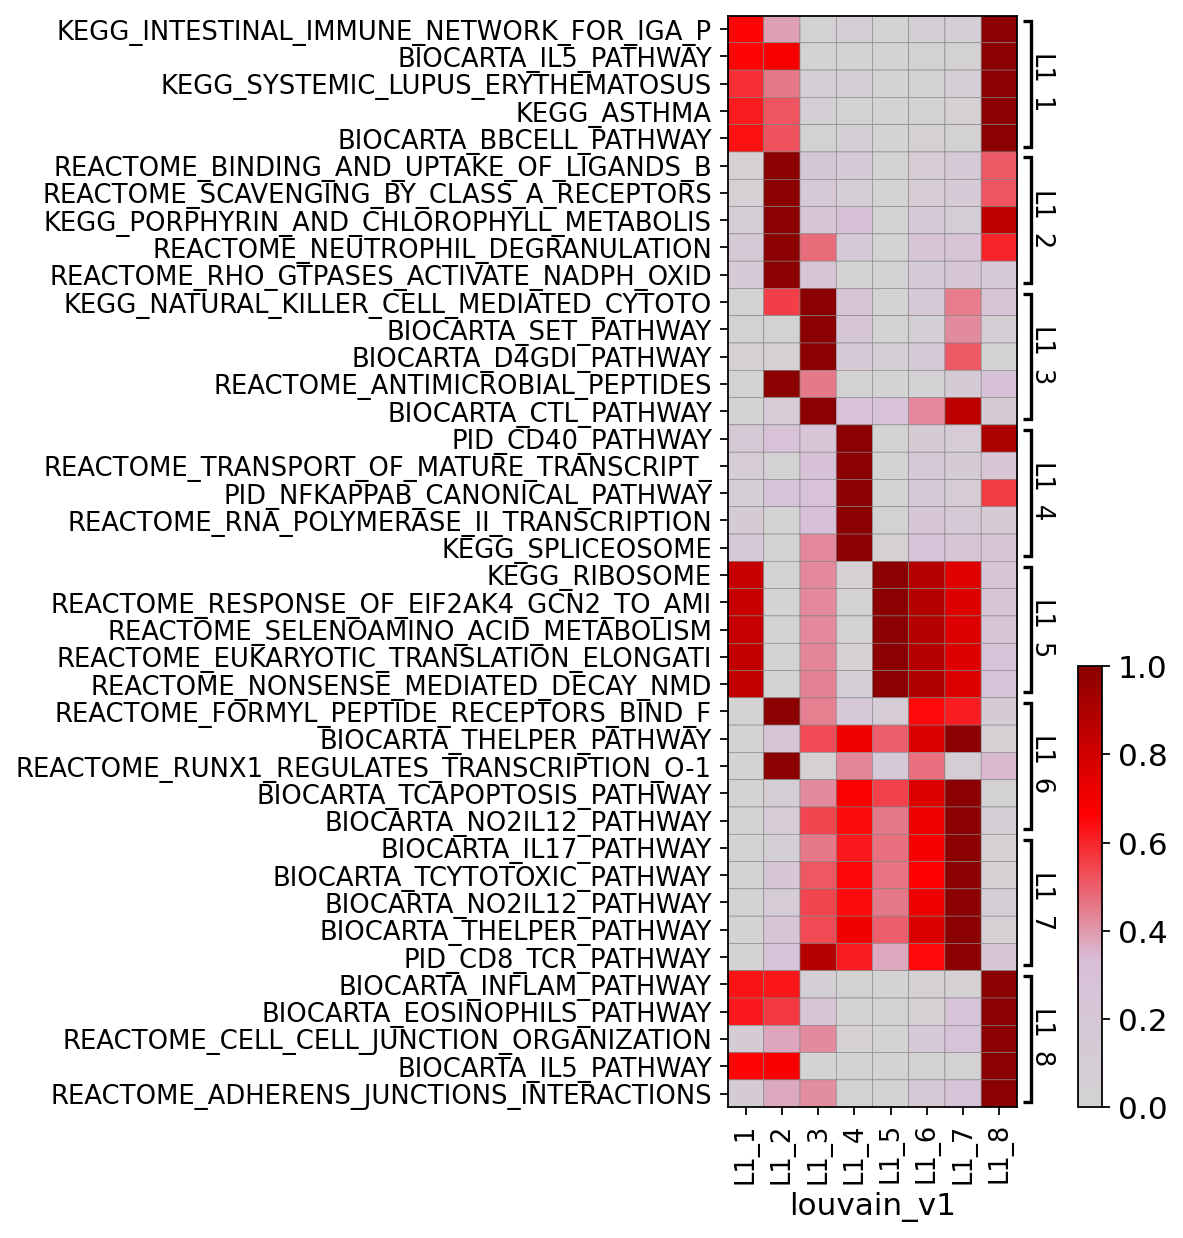

GridSpec(2, 3, height_ratios=[0, 8.0], width_ratios=[2.4, 0.4, 0.2])

In [48]:
sc.pl.matrixplot(c2DB, var_names=ordered, groupby='louvain_v1', standard_scale='var', cmap=cmap, swap_axes=True, save='_PBMC_leiden_v1_Top5c2DB.pdf')

In [16]:
c2DB.write('./write/PBMC_Tcells_c2DB.h5ad')

biomarker database

In [17]:
with open('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Files/Pathway_DB/Biomarkers_DB.gmt') as f:
    DBcont = f.readlines()
BMDBres = smqpp.pathway_score_cal(adata, DBcont)
BMDB = anndata.AnnData(BMDBres, obs=adata.obs,  obsm=adata.obsm)
BMDB.var_names = [x[0:40] for x in BMDBres.columns]
BMDB.var_names_make_unique()
sc.tl.rank_genes_groups(BMDB, 'louvain_v1', n_genes=BMDB.shape[1], key_added='DE_louvain_v1', method='t-test')

ranking genes
    finished: added to `.uns['DE_louvain_v1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


Index(['L1_1', 'L1_2', 'L1_3', 'L1_4', 'L1_5', 'L1_6', 'L1_7', 'L1_8'], dtype='object')
0
(15293, 482)
(15293, 482)
upRegulated gene: 20
downRegulated gene: 38


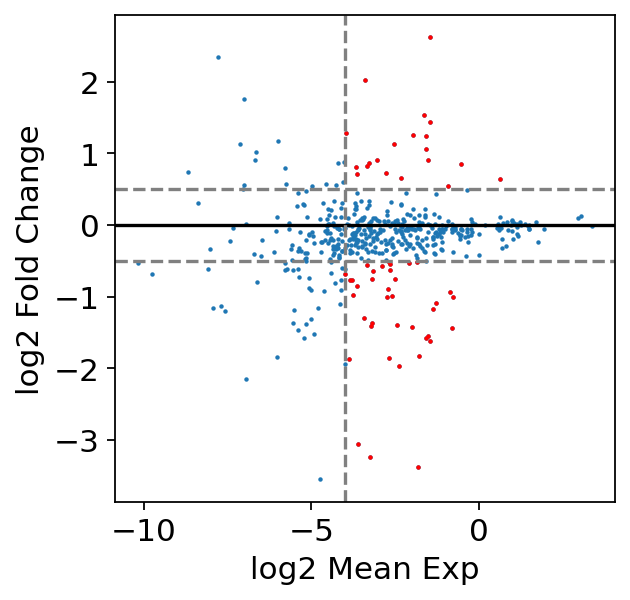

1
(15293, 482)
(15293, 482)
upRegulated gene: 139
downRegulated gene: 49


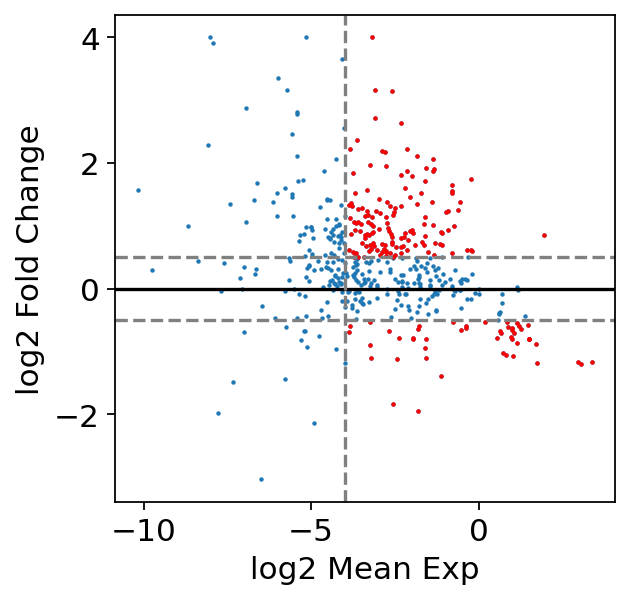

2
(15293, 482)
(15293, 482)
upRegulated gene: 81
downRegulated gene: 5


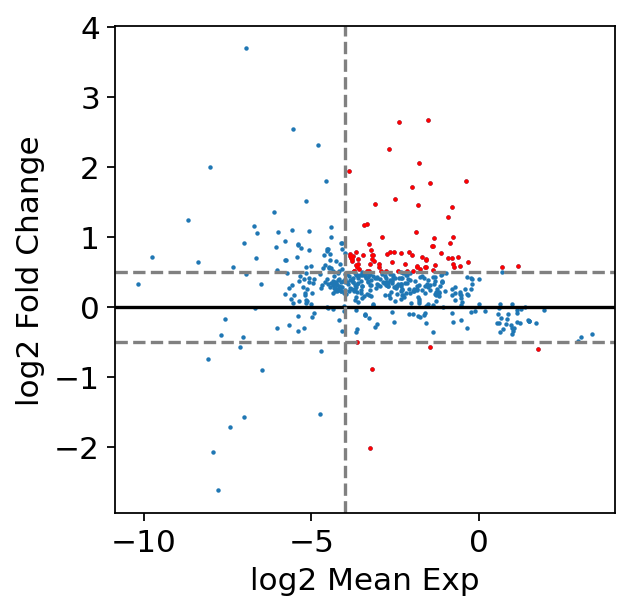

3
(15293, 482)
(15293, 482)
upRegulated gene: 64
downRegulated gene: 37


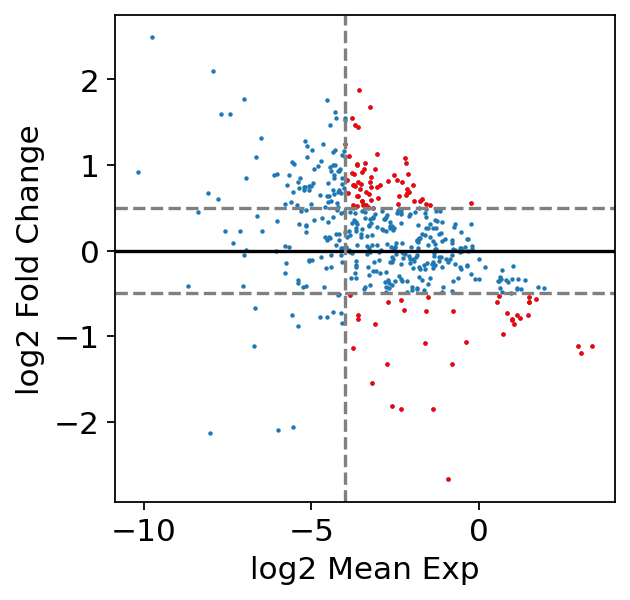

4
(15293, 482)
(15293, 482)
upRegulated gene: 0
downRegulated gene: 136


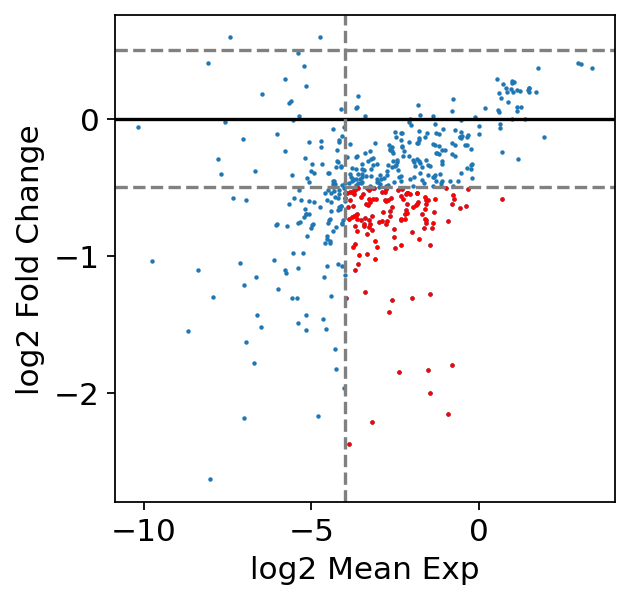

5
(15293, 482)
(15293, 482)
upRegulated gene: 7
downRegulated gene: 8


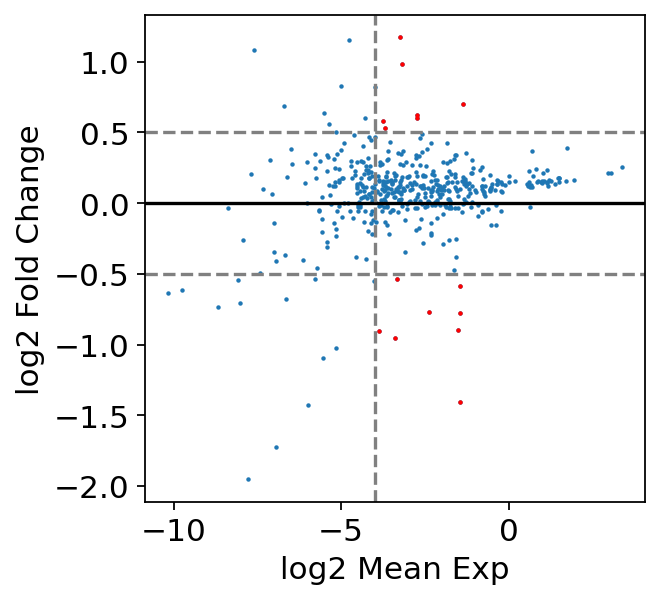

6
(15293, 482)
(15293, 482)
upRegulated gene: 29
downRegulated gene: 7


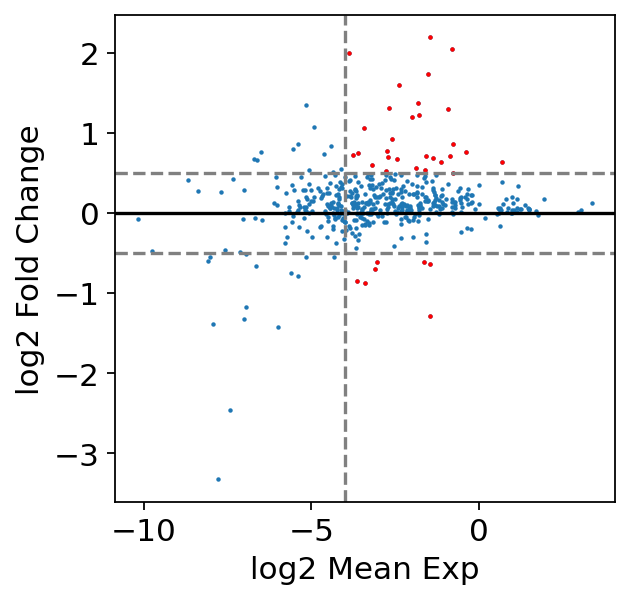

7
(15293, 482)
(15293, 482)
upRegulated gene: 111
downRegulated gene: 22


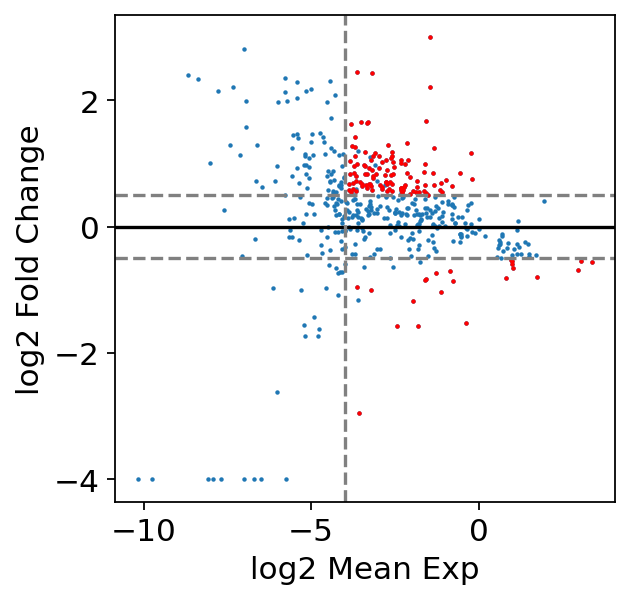

In [18]:
cat = BMDB.obs['louvain_v1'].cat.categories
print(cat)
BMDB.raw= BMDB
for x in range(len(cat)):
    print(x)
    upG, downG, tableG = smqpp.plot_ma(BMDB, 'DE_louvain_v1',cidx=int(x), padj_cutoff=0.05, logFC_cutoff=0.5, exp_cutoff=-4)
    np.savetxt('Pathway/PBMC_louvain_v1_BMDB/'+cat[x]+'vsAll_upG.txt', upG, delimiter='\t', fmt='%s')
    np.savetxt('Pathway/PBMC_louvain_v1_BMDB/'+cat[x]+'vsAll_downG.txt', downG, delimiter='\t', fmt='%s')
    tableG.to_csv('Pathway/PBMC_louvain_v1_BMDB/'+cat[x]+'vsAll_table.csv')

In [19]:
import os
import re
GL2plot = {}
files = np.array(os.listdir('./Pathway/PBMC_louvain_v1_BMDB/'))
files = files[['upG' in x for x in files]]
print(files)
for f in files:
    cl = re.search('L1_\d+' , f)[0]
    GL2plot[cl] = np.genfromtxt('./Pathway/PBMC_louvain_v1_BMDB/'+f, dtype=str, delimiter='\t')

['L1_4vsAll_upG.txt' 'L1_8vsAll_upG.txt' 'L1_1vsAll_upG.txt'
 'L1_2vsAll_upG.txt' 'L1_6vsAll_upG.txt' 'L1_3vsAll_upG.txt'
 'L1_5vsAll_upG.txt' 'L1_7vsAll_upG.txt']


/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: genfromtxt: Empty input file: "./Pathway/PBMC_louvain_v1_BMDB/L1_5vsAll_upG.txt"
  if __name__ == '__main__':


In [20]:
from collections import OrderedDict
ordered = OrderedDict()
for k in BMDB.obs['louvain_v1'].cat.categories:
    if type(GL2plot[k].tolist()) == list:
        ordered[k] = GL2plot[k][0:5]
    else:
        ordered[k] =GL2plot[k].tolist()

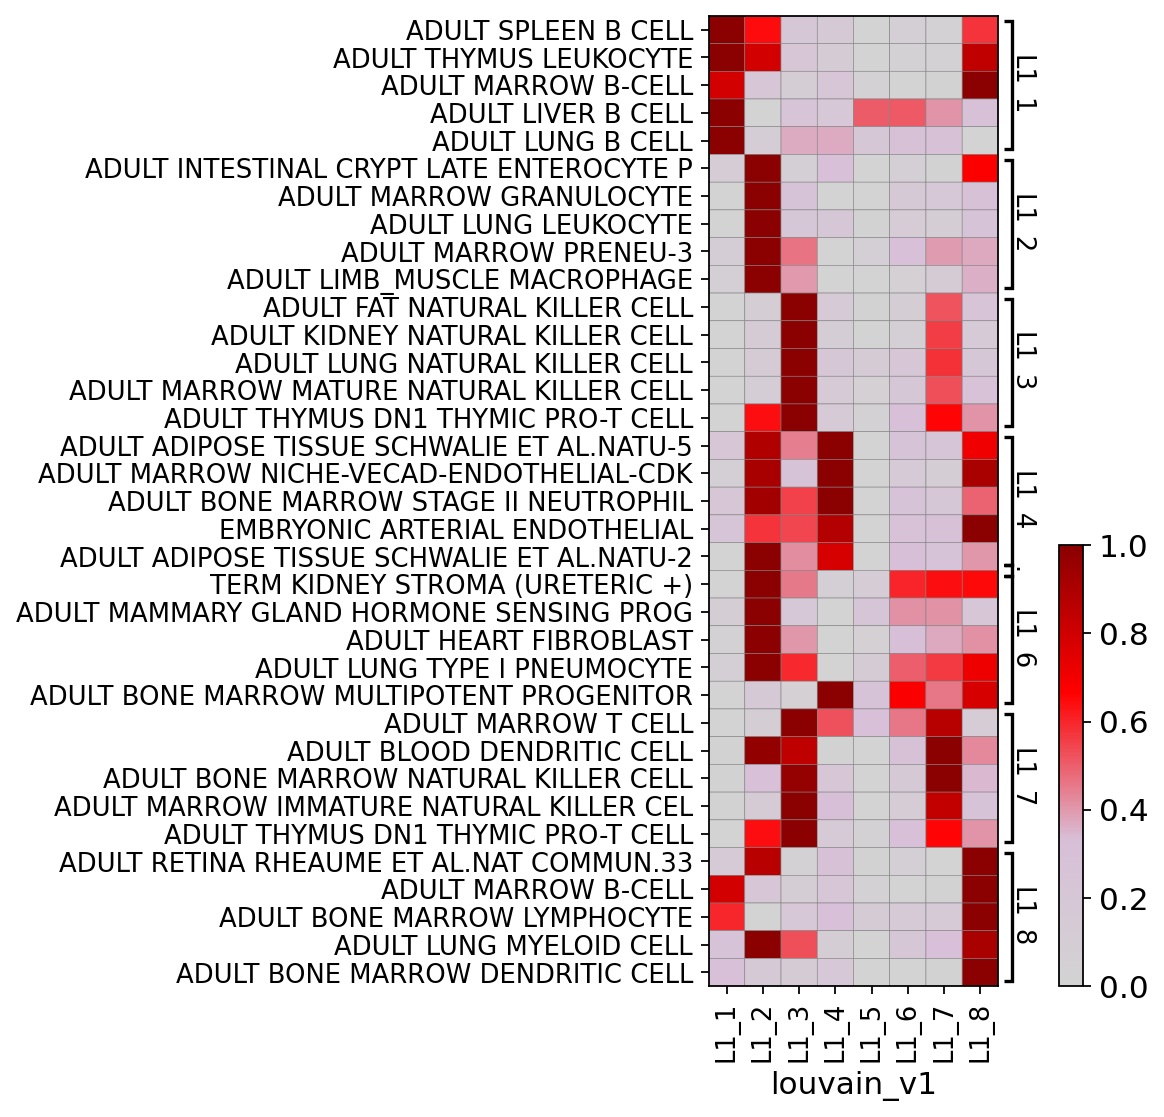

GridSpec(2, 3, height_ratios=[0, 7.0], width_ratios=[2.4, 0.4, 0.2])

In [21]:
sc.pl.matrixplot(BMDB, var_names=ordered, groupby='louvain_v1', standard_scale='var', cmap=cmap, swap_axes=True)

In [22]:
BMDB.write('./write/PBMC_Tcells_BMDB.h5ad')

# Save T cells data for analysis separately

In [44]:
# Fernando doesn't like it, redo
# Tcellsidx = [('CD4' in x) | ('CD8' in x) for x in adata.obs['Proj_PBMC68K']]
# TcellsD = adata[Tcellsidx].copy()
# print(TcellsD.shape)
# TcellsD.write('./write/PBMC_Tcells.h5ad')

In [28]:
adata = sc.read('./write/PBMC_processed.h5ad')

In [29]:
print(adata.obs_keys())

['Barcode', 'Donor', 'Vector', 'batch', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'phase', 'S_score', 'G2M_score', 'Proj_PBMC68K', 'louvain_v1', 'phase_comb', 'RPscore', 'Proj_PBMC68K_new']


In [22]:
groups = ['L1_4', 'L1_5', 'L1_6', 'L1_7']

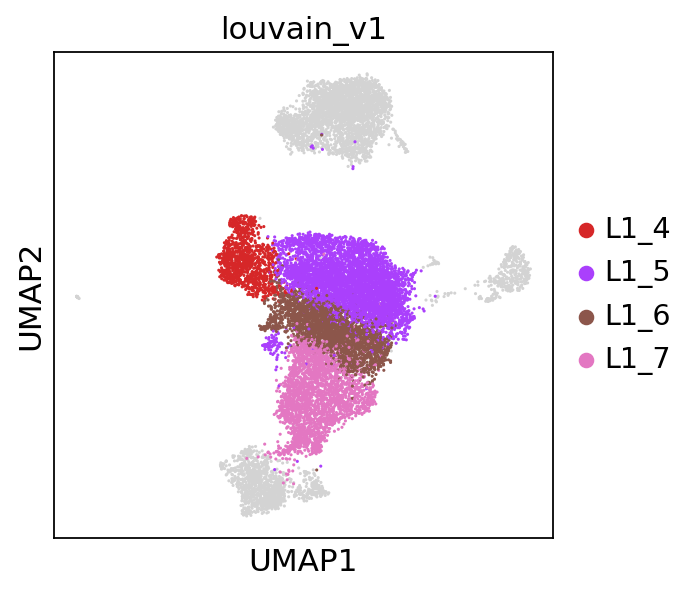

In [23]:
sc.pl.umap(adata, color='louvain_v1', groups=groups, save='_PBMC_Tcells_basedon_louvain.pdf')

In [42]:
sc.pl.palettes.vega_20

['#1f77b4',
 '#aec7e8',
 '#ff7f0e',
 '#ffbb78',
 '#2ca02c',
 '#98df8a',
 '#d62728',
 '#ff9896',
 '#9467bd',
 '#c5b0d5',
 '#8c564b',
 '#c49c94',
 '#e377c2',
 '#f7b6d2',
 '#7f7f7f',
 '#c7c7c7',
 '#bcbd22',
 '#dbdb8d',
 '#17becf',
 '#9edae5']

In [45]:
adata.obs['Tcells'] = ['T cells' if x in groups else '' for x in adata.obs['louvain_v1']]
adata.uns['Tcells_colors'] = ['#d3d3d3', '#1f77b4']

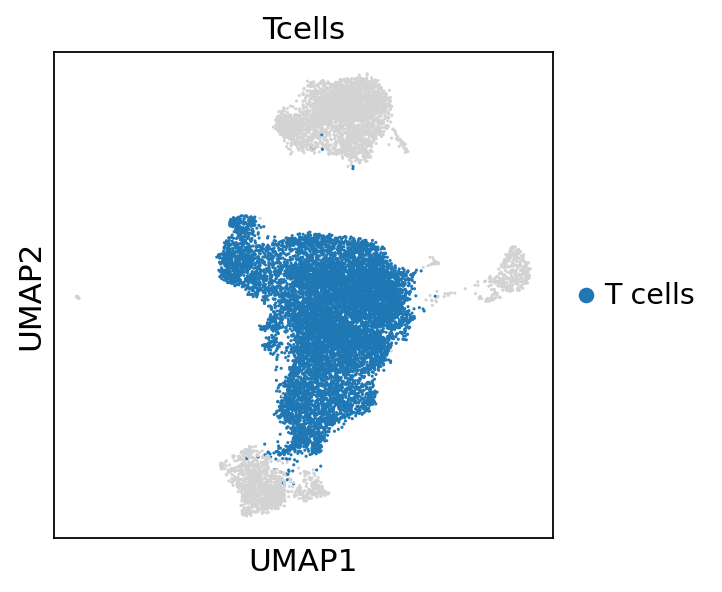

In [47]:
sc.pl.umap(adata, color='Tcells', save='_PBMC_Tcells_Tcellsonly.pdf')

In [48]:
adata.write('./write/PBMC_processed.h5ad')

In [24]:
adata_Tcells = adata[[True if x in groups else False for x in adata.obs['louvain_v1']]].copy()

In [25]:
adata_Tcells.write('./write/PBMC_Tcells.h5ad')

# Subplots

In [12]:
GL = ['FTL', 'S100A8', 'CD14', 'GNLY', 'NKG7', 'CD19', 'CD79A', 'CD3D', 'CD8A', 'CD4']

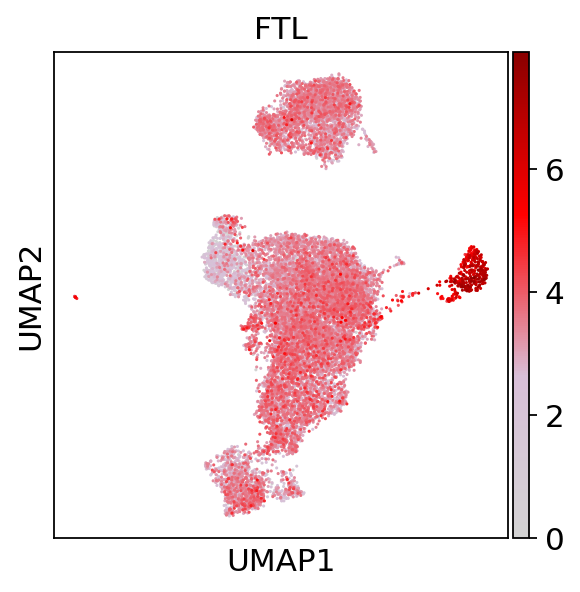

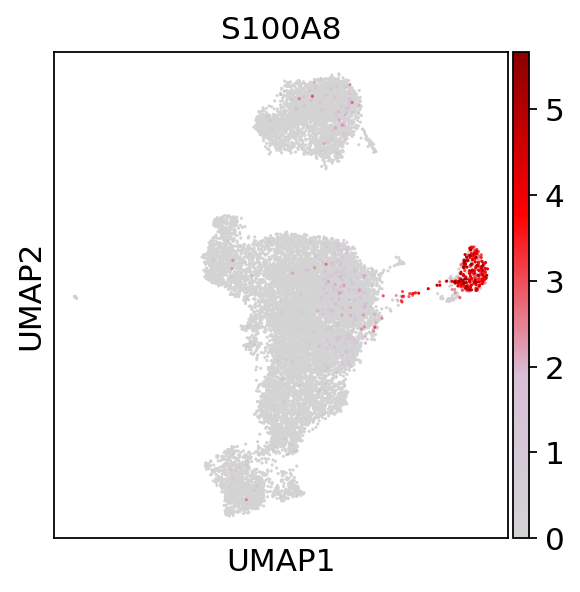

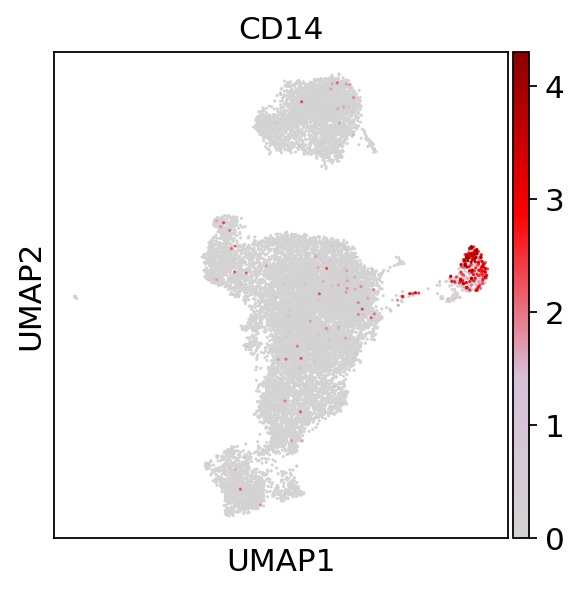

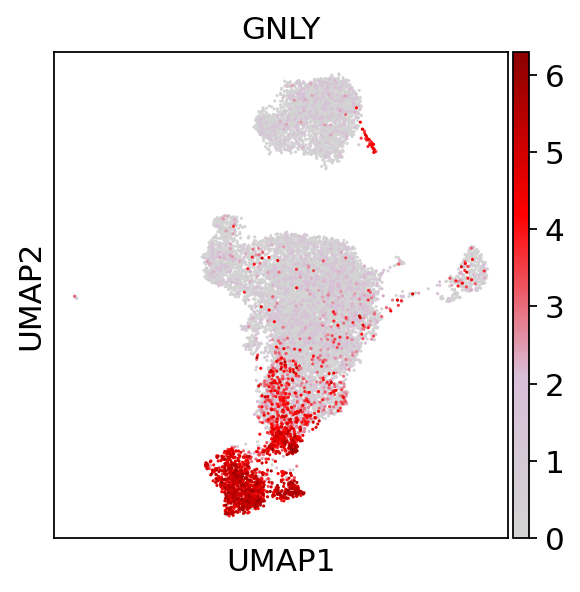

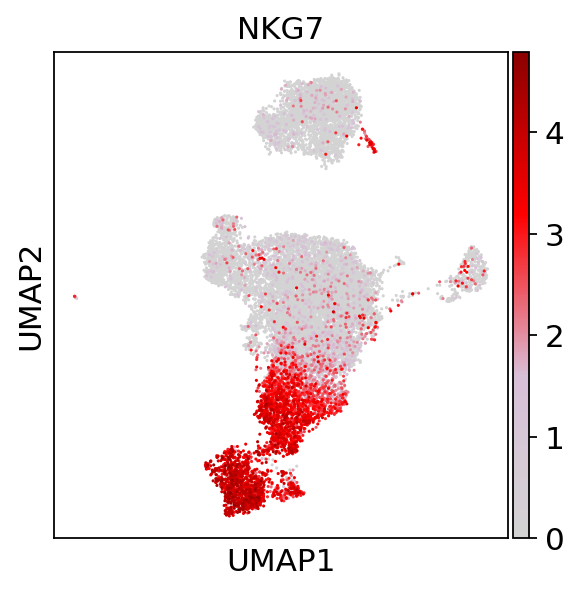

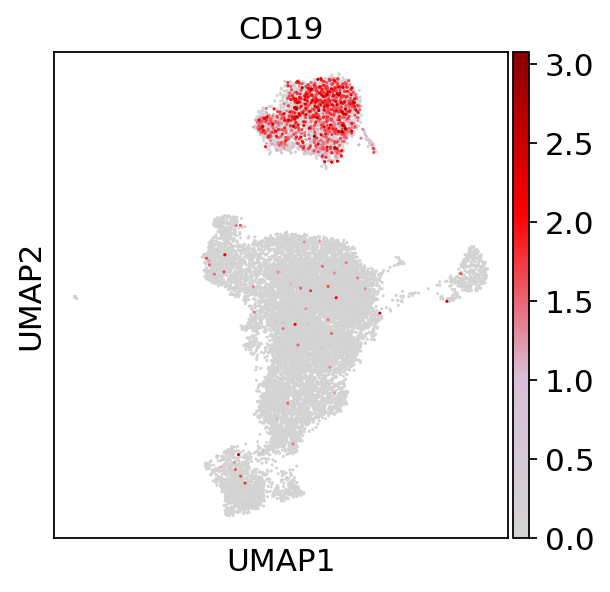

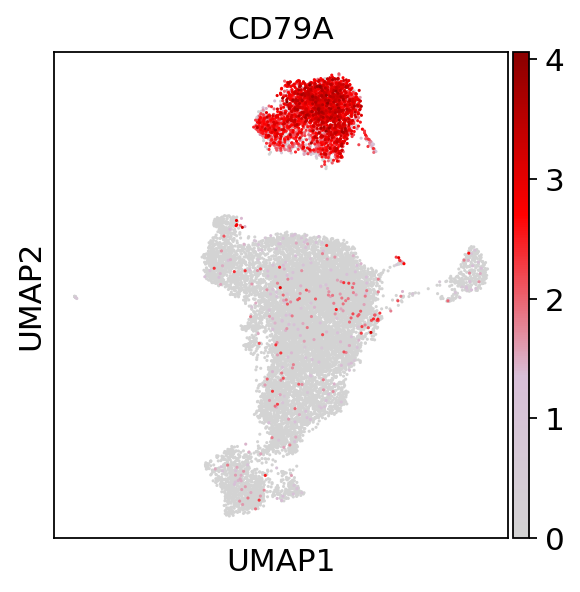

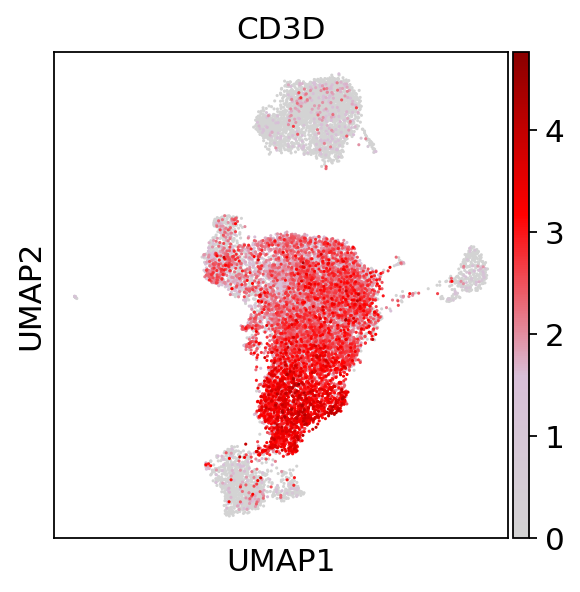

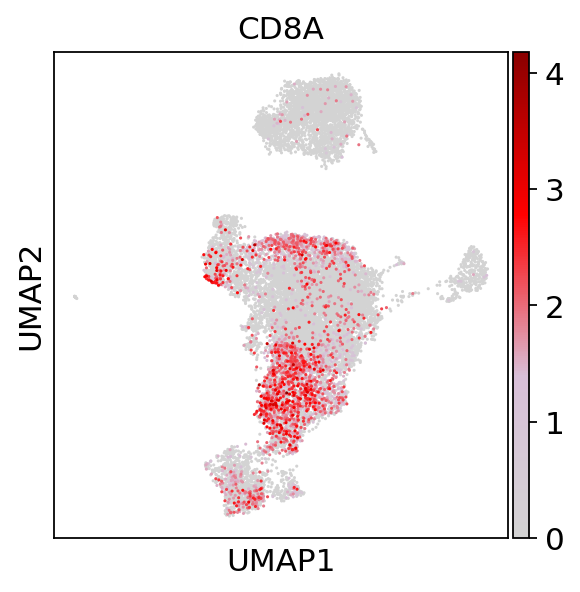

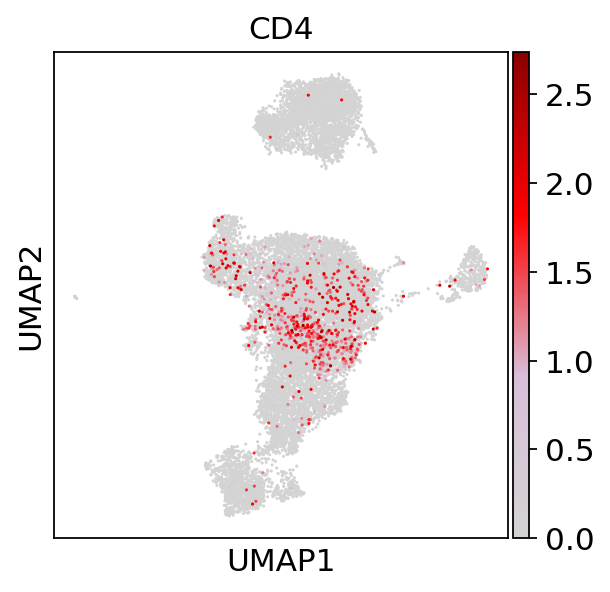

In [13]:
for i in GL:
    sc.pl.umap(adata, color=i, color_map=cmap, title=i, save='_PBMC_'+i+'.pdf')

Proj_PBMC68K_new  CD14+ Monocyte  CD19+ B  CD34+  CD56+ NK  Dendritic  T cells
Donor                                                                         
Donor1                       283      888      0       210         49     3754
Donor2                         8      793      0       586          0     3749
Donor3                         1     1224      1       354          0     3393

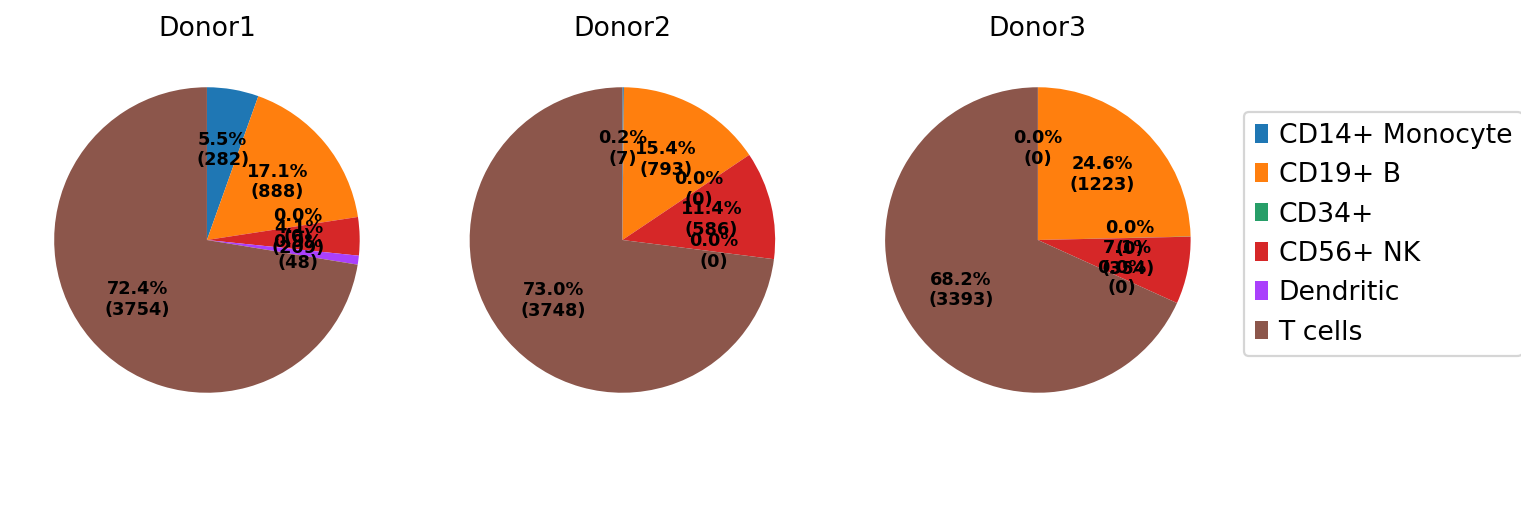

In [25]:
lv_stat_barplot(adata, fontsize=12, splitby="Donor", colorby="Proj_PBMC68K_new", plotMethod="PieChart", color=adata.uns['Proj_PBMC68K_new_colors'], save='PBMC_donor.pdf', figsize=(8,5))

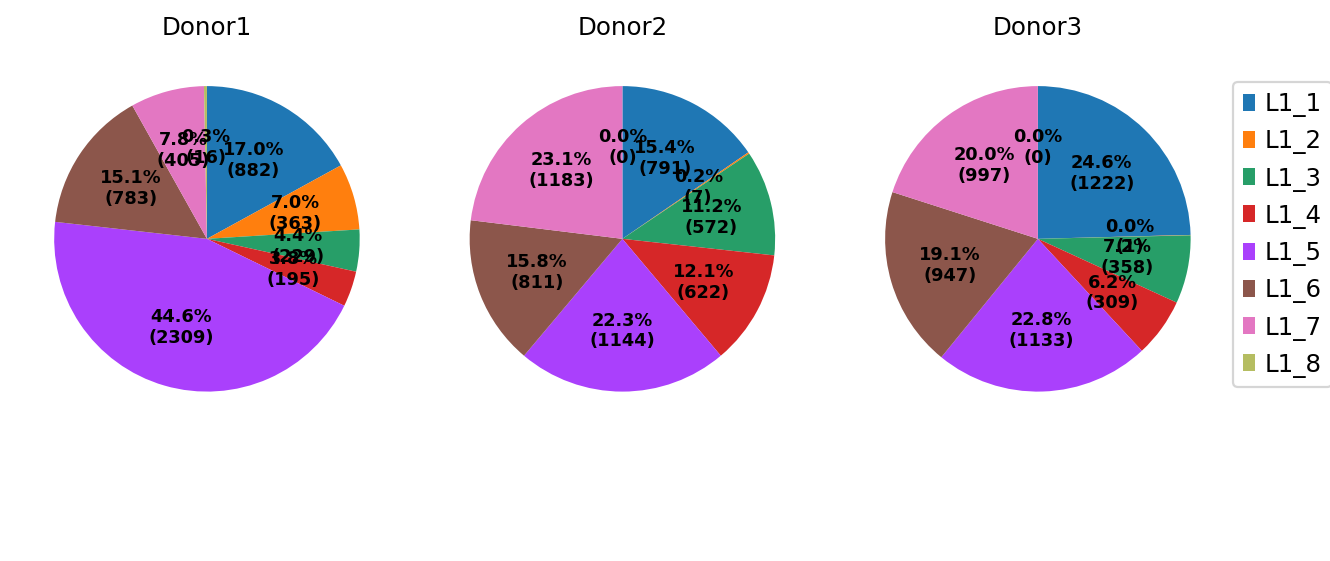

In [11]:
FN = 'piechart_PBMC_donor_louvainv1'
df = lv_stat_barplot(adata, fontsize=11, splitby="Donor", colorby="louvain_v1", plotMethod="PieChart", color=adata.uns['louvain_v1_colors'],  save=FN+'.pdf', figsize=(8,6), bbox_to_anchor=(1.05,0.34))
df.to_csv('./table/'+FN+'.csv')

# Double check

In [6]:
adata = sc.read('./write/PBMC_processed.h5ad')

In [27]:
print(adata.shape)

(15293, 1527)
